In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import shap
from shap.maskers import Independent
import tqdm as notebook_tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, log_loss
from scipy.stats import norm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler

/home/abhishek.f/.conda/envs/TF_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df1 = pd.read_excel('../Dataset/CRC_EVs_ZP_150724.xlsx', sheet_name = 'Cell_1_hPSC EVs')

In [3]:
df2 = pd.read_excel('../Dataset/CRC_EVs_ZP_150724.xlsx', sheet_name = 'Cell_2_Caco2 EVs')

In [4]:
df3 = pd.read_excel('../Dataset/CRC_EVs_ZP_150724.xlsx', sheet_name = 'Cell_3_DLD-1 EVs')

In [5]:
df1 = df1.iloc[1:]
df2 = df2.iloc[1:]
df3 = df3.iloc[1:]

In [6]:
columns = ['Record', 'Type', 'Measurement Date and Time', 'T',
       'Surface Zeta Potential', 'Surface Zeta Potential Uncertainty','Mob',
        'Tracer Zeta Potential']

In [7]:
df1.drop(columns = columns, inplace = True)
df2.drop(columns = columns, inplace = True)
df3.drop(columns = columns, inplace = True)

In [8]:
def redefine_sample_name(sample):
    if 'hPSC_EV' in sample:
        return 0
    else:
        return 1

In [9]:
dataset1 = pd.concat([df1, df2], axis = 0)
dataset2 = pd.concat([df1, df3], axis = 0)

In [10]:
dataset1['Sample Name'] = dataset1['Sample Name'].apply(redefine_sample_name)
dataset2['Sample Name'] = dataset2['Sample Name'].apply(redefine_sample_name)

In [11]:
columns = ['Zeta Potential', 'Cond', 'Mean Count Rate']

In [12]:
dataset1[columns] = dataset1[columns].astype(float)
dataset2[columns] = dataset2[columns].astype(float)

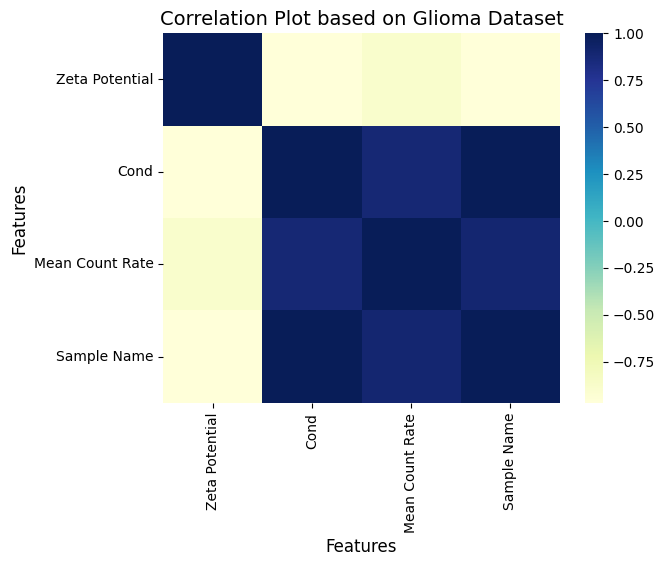

In [13]:
#========================Creating correlation matrix for the Glioma datastet==================================
columns = ['Zeta Potential', 'Cond', 'Mean Count Rate', 'Sample Name']

correlation_matrix = dataset1[columns].corr()
# Create a correlation plot
sns.heatmap(correlation_matrix, cmap='YlGnBu')
# Add plot title and adjust font size
plt.title('Correlation Plot based on Glioma Dataset', fontsize=14)
# Set the font size of the axis labels
plt.xlabel('Features', fontsize=12)
plt.ylabel('Features', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
# Show the plot
plt.show()
#==========================================================================================================

In [14]:
train_set = [0.70, 0.50, 0.1, 0.01, 0.005]

In [15]:
training_sample = []
for i in range(len(train_set)):
    training_sample.append(train_set[i] * 100)

In [16]:
#================Method to evaluate classical ML models==============
def evaluate_model(model, train_set, X_train, y_train, X_test, y_test):
    acc_ls = []
    pred_ls = []
    train_data = []
    pred_proba_ls = []
    for elm in train_set:
        clf = copy.copy(model)
        X_t, dummy_x, y_t, dummy_y = train_test_split(copy.copy(X_train), y_train, train_size=elm, random_state=123)
        # Fitting the classifier to the training data
        clf.fit(X_t, y_t)
        train_data.append(y_t)
        # Making predictions on the testing data
        y_pred = clf.predict(X_test)
        y_pred_proba = clf.predict_proba(X_t)
        pred_ls.append(y_pred)
        pred_proba_ls.append(y_pred_proba)
        # Evaluating the accuracy of the model
        accuracy = accuracy_score(y_test, y_pred)
        acc_ls.append(accuracy)
        print(f'Accuracy score({clf.__class__.__name__} model): {accuracy:.6f} with {elm*100}% training records')
    return acc_ls, pred_ls, train_data, pred_proba_ls

In [17]:
#=====================Method to show ROC Curve of the model based on different training set===========================
def evaluate_ROC(train_set, y_test, pred_ls):
    for i in range(len(train_set)):
        # Compute the ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(y_test, pred_ls[i])
        roc_auc = auc(fpr, tpr)
        # Compute the confidence interval
        std_err = np.sqrt(np.divide(tpr * (1 - tpr), y_test.size, where=(y_test.size != 0)) * (fpr + tpr))
        # Compute the confidence interval with explicit broadcasting
        upper_bound = tpr + std_err * 1.96
        lower_bound = tpr - std_err * 1.96
        # Plot the ROC curve
        plt.figure()
        plt.plot(fpr, tpr, color='b', label='AUC = %0.2f' % roc_auc)
        plt.fill_between(fpr, lower_bound, upper_bound, color='lightblue', alpha=0.5,label = '\n95%% CI: [%0.2f, %0.2f]' % (lower_bound[1], upper_bound[1]))
        plt.plot([0, 1], [0, 1], color='r', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title(f'ROC Curve (95% CI), {train_set[i]*100}% Training Data')
        plt.legend(loc="lower right")
        plt.show()

In [18]:
#=========================Method to show Confusion Matrix on different Training Set==============================
def evaluate_con_mat(train_set, y_test, pred_ls):
    for i in range(len(train_set)):
        # Calculate the confusion matrix
        cm = confusion_matrix(y_test, pred_ls[i])
        # Create a heatmap of the confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix ({train_set[i]*100}% Training Data)')
        plt.show()

# <center>hPSC-EVs vs Caco2-EVs</center>

In [20]:
#==================Predictor Variables=====================================
X = dataset1[['Zeta Potential', 'Cond', 'Mean Count Rate']]
#X = dataset.drop(['Grade','Age_in_years'], axis = 1)
#===================Output Variable========================================
y = dataset1['Sample Name']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)

## Logistic Regression

### Logistic Regression without Hyperparameter Tuning (hPSC-EVs vs Caco2-EVs)

In [21]:
eval_mod=evaluate_model(LogisticRegression(solver = 'lbfgs', max_iter=1000), train_set, X_train, y_train, X_test, y_test)

Accuracy score(LogisticRegression model): 1.000000 with 70.0% training records
Accuracy score(LogisticRegression model): 1.000000 with 50.0% training records
Accuracy score(LogisticRegression model): 0.996667 with 10.0% training records
Accuracy score(LogisticRegression model): 0.990000 with 1.0% training records
Accuracy score(LogisticRegression model): 0.980000 with 0.5% training records


In [22]:
del eval_mod

In [23]:
#===============================Hyperparameter Tuning================================
from sklearn.exceptions import ConvergenceWarning
# Supressing Warning related to convergence
warnings.filterwarnings("ignore", category=ConvergenceWarning)

clf_LR = LogisticRegression(solver = 'lbfgs', max_iter=1000)
param_grid = { 'C': [0.001, 0.01, 0.1, 1, 10, 100],'penalty': ['l2'], 'solver': ['newton-cg','lbfgs' ,'liblinear', 'saga']}
grid_search = GridSearchCV(clf_LR, param_grid, cv=10, verbose=0 ,scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

Best hyperparameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}


In [24]:
best_model = grid_search.best_estimator_
# Use SHAP's LinearExplainer with the best model
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    explainer = shap.LinearExplainer(best_model, X_train, feature_perturbation="interventional")
    shap_values = explainer.shap_values(X_test)

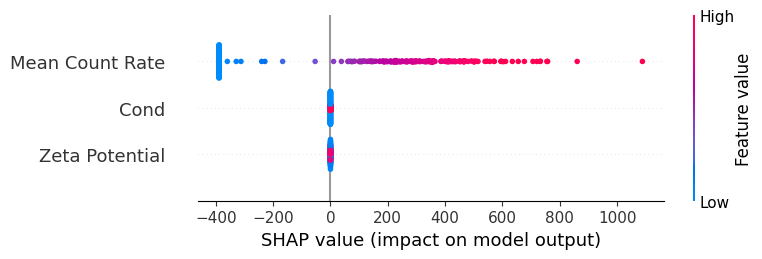

In [25]:
shap.summary_plot(shap_values,X_test)

### Logistic Regression Model with Hyperparameter Tuning (hPSC-EVs vs Caco2-EVs)

In [26]:
#==============================Logistic Regression Model with Hyperparameter Tuning===========================
acc_LR, pred_LR, train_data, pred_proba_LR = evaluate_model(LogisticRegression(solver = best_params['solver'], penalty=best_params['penalty'], C = best_params['C']), train_set, X_train, y_train, X_test, y_test)

Accuracy score(LogisticRegression model): 1.000000 with 70.0% training records
Accuracy score(LogisticRegression model): 1.000000 with 50.0% training records
Accuracy score(LogisticRegression model): 0.996667 with 10.0% training records
Accuracy score(LogisticRegression model): 0.990000 with 1.0% training records
Accuracy score(LogisticRegression model): 0.980000 with 0.5% training records


### Learning Curve for Logistic Regression

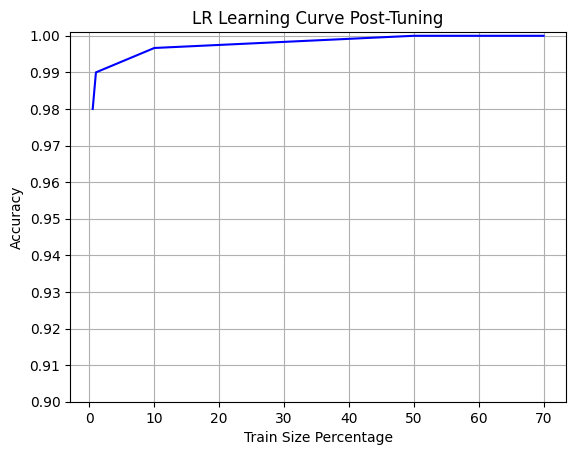

In [27]:
#===============================Learning Curve for LR===========================================
plt.plot(training_sample,acc_LR, color = 'b', )
plt.xticks([0,10, 20, 30, 40, 50, 60, 70])
plt.yticks([0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.0])
plt.grid()
plt.xlabel('Train Size Percentage')
plt.ylabel('Accuracy')
plt.title('LR Learning Curve Post-Tuning')
plt.show()

#### ROC Curve for Logistic Regression (hPSC-EVs vs Caco2-EVs)

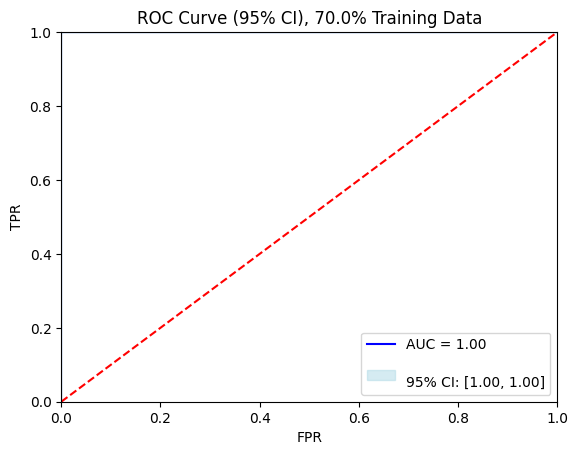

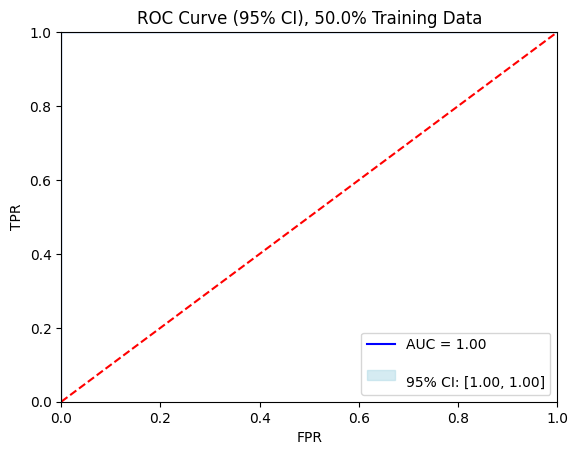

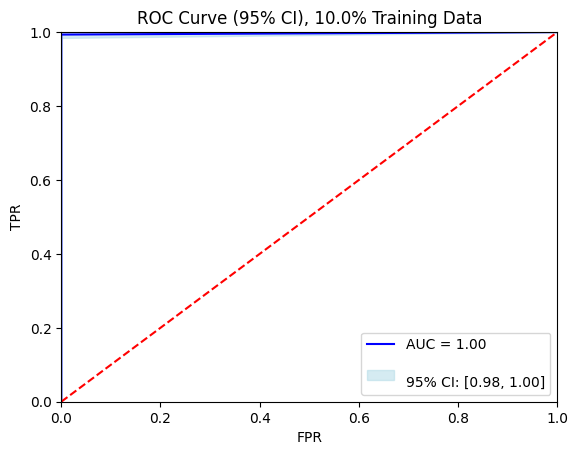

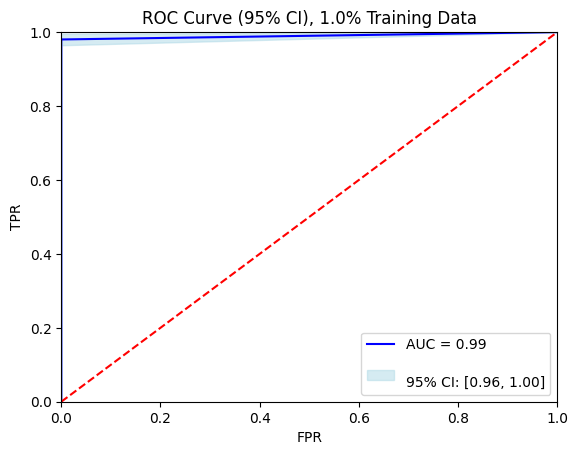

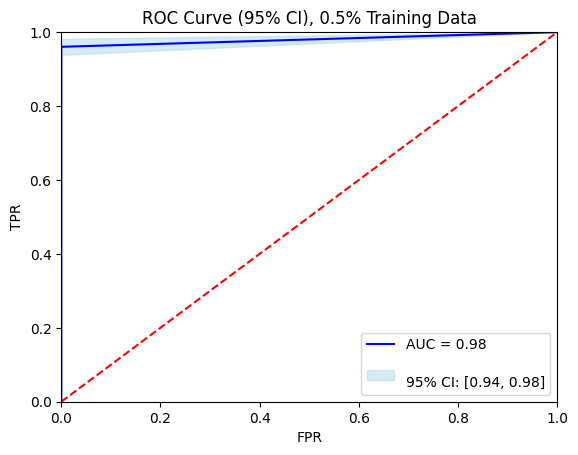

In [28]:
evaluate_ROC(train_set, y_test, pred_LR)

### Confusion Matrix for Logistic Regression (hPSC-EVs vs Caco2-EVs)

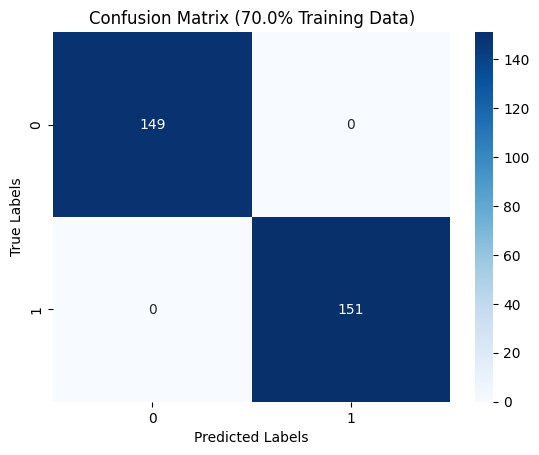

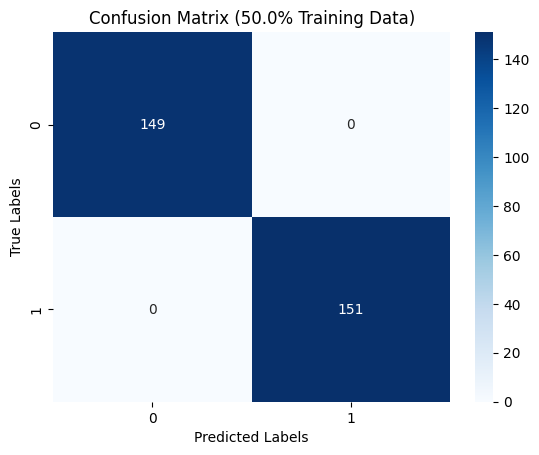

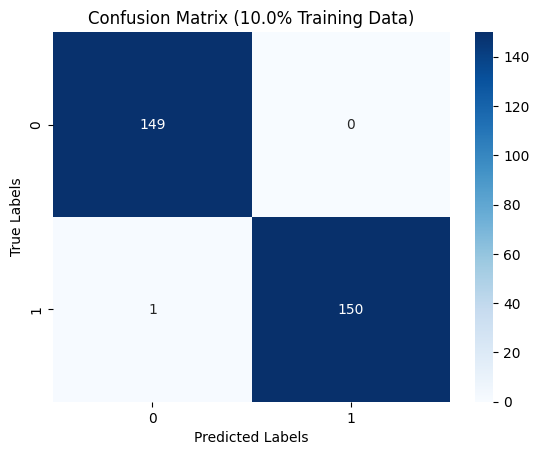

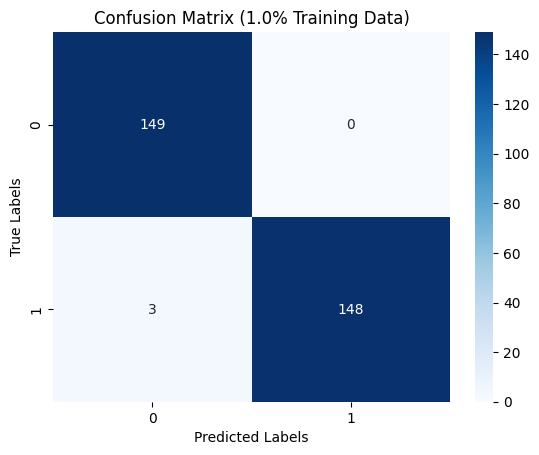

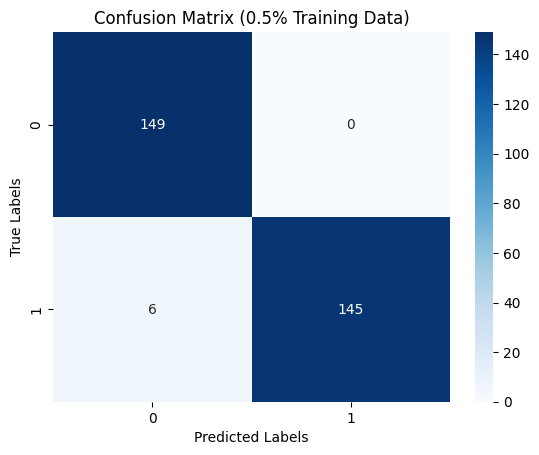

In [29]:
evaluate_con_mat(train_set, y_test, pred_LR)

### Cost/Loss Function of Logistic Regression Model with various Training Data (hPSC-EVs vs Caco2-EVs)

In [30]:
for i, y_t in enumerate(train_data):
    cost = log_loss(y_t, pred_proba_LR[i])
    print(f'LR Cost: {cost:.10f} ({train_set[i]*100}% train)')

LR Cost: 0.0001694024 (70.0% train)
LR Cost: 0.0002311433 (50.0% train)
LR Cost: 0.0000342582 (10.0% train)
LR Cost: 0.0001134238 (1.0% train)
LR Cost: 0.0000275709 (0.5% train)


In [31]:
del acc_LR, pred_LR, train_data, pred_proba_LR, y_t, best_params, clf_LR, cost

## Support Vector Classifier

### Support Vector Classifier without Hyperparameter Tuning (hPSC-EVs vs Caco2-EVs)

In [32]:
eval_mod=evaluate_model(SVC(probability=True), train_set, X_train, y_train, X_test, y_test)

Accuracy score(SVC model): 0.990000 with 70.0% training records
Accuracy score(SVC model): 0.990000 with 50.0% training records
Accuracy score(SVC model): 0.990000 with 10.0% training records
Accuracy score(SVC model): 0.986667 with 1.0% training records
Accuracy score(SVC model): 0.973333 with 0.5% training records


In [33]:
del eval_mod

In [34]:
#==========================Hyperparameter Tuning==========================
clf_SVM = SVC(probability=True)
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel type
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],  # Kernel coefficient
}
grid_search = GridSearchCV(estimator=clf_SVM, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

Best hyperparameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


Using 700 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 300/300 [00:21<00:00, 14.00it/s]


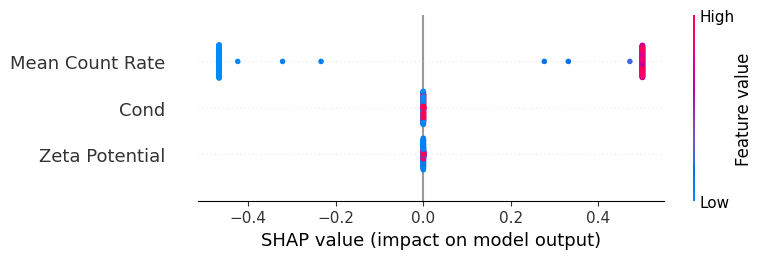

In [35]:
best_model = grid_search.best_estimator_
explainer_svc = shap.KernelExplainer(best_model.predict_proba, X_train)
shap_values_svc = explainer_svc(X_test)
shap_values_svc_class_1 = shap_values_svc.values[..., 1]
shap.summary_plot(shap_values_svc_class_1, X_test)

### Support Vector Classifier with Hyperparameter Tuning (hPSC-EVs vs Caco2-EVs)

In [36]:
acc_SVC, pred_SVC, train_data, pred_proba_SVC=evaluate_model(SVC(C = best_params['C'], gamma = best_params['gamma'], kernel = best_params['kernel'], probability=True), train_set, X_train, y_train, X_test, y_test)

Accuracy score(SVC model): 1.000000 with 70.0% training records
Accuracy score(SVC model): 1.000000 with 50.0% training records
Accuracy score(SVC model): 0.996667 with 10.0% training records
Accuracy score(SVC model): 0.993333 with 1.0% training records
Accuracy score(SVC model): 0.980000 with 0.5% training records


### Learning Curve for SVC

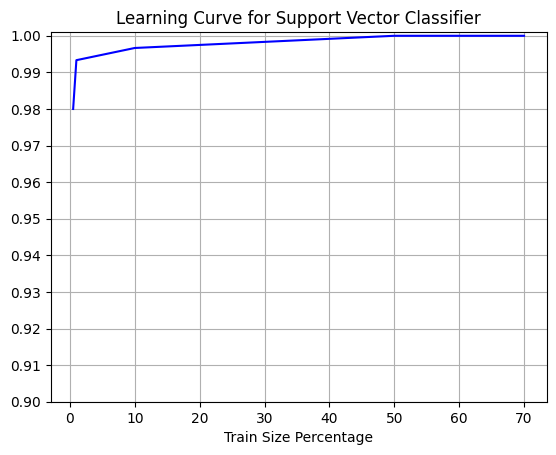

In [37]:
#===============================Learning Curve for SVC===========================================
plt.plot(training_sample,acc_SVC, color = 'b', )
plt.xticks([0,10, 20, 30, 40, 50, 60, 70])
plt.yticks([0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.0])
plt.grid()
plt.xlabel('Train Size Percentage')
plt.title('Learning Curve for Support Vector Classifier')
plt.show()

### ROC Curve for Support Vector Classifier (hPSC-EVs vs Caco2-EVs)

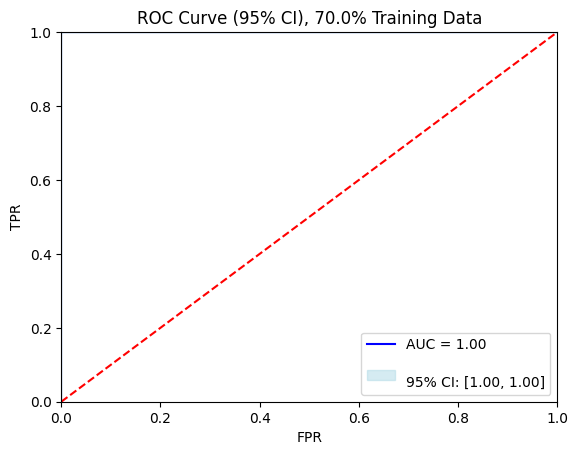

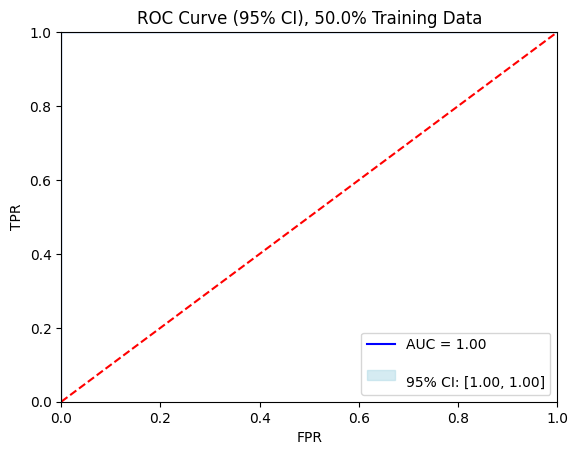

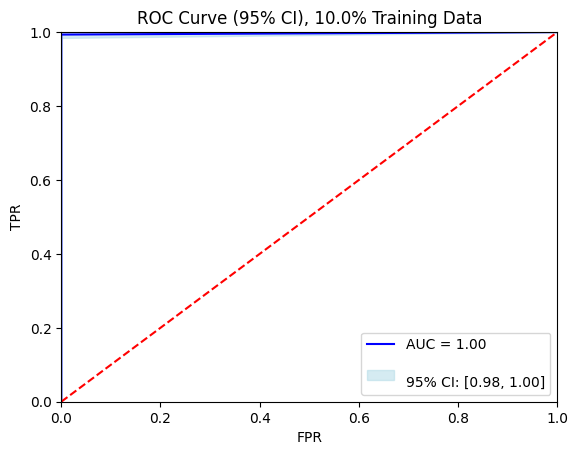

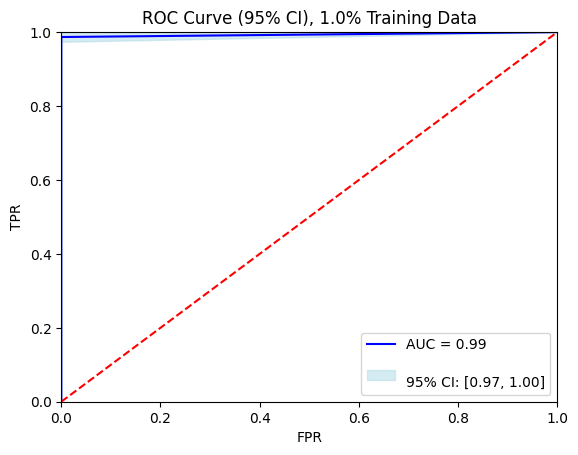

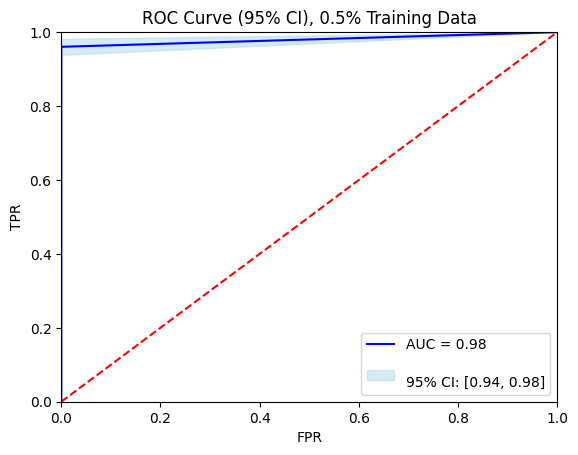

In [38]:
evaluate_ROC(train_set, y_test, pred_SVC)

### Confusion Matrix for Support Vector Classifier (hPSC-EVs vs Caco2-EVs)

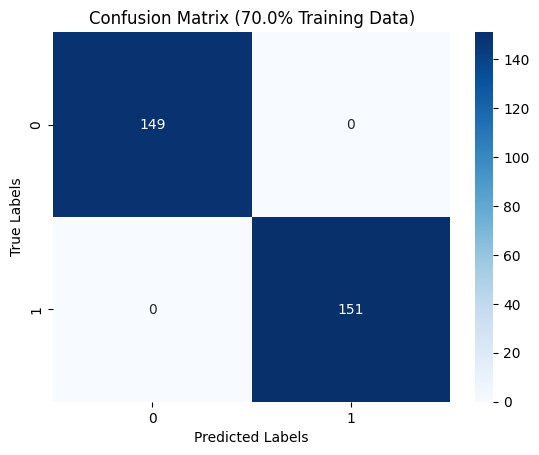

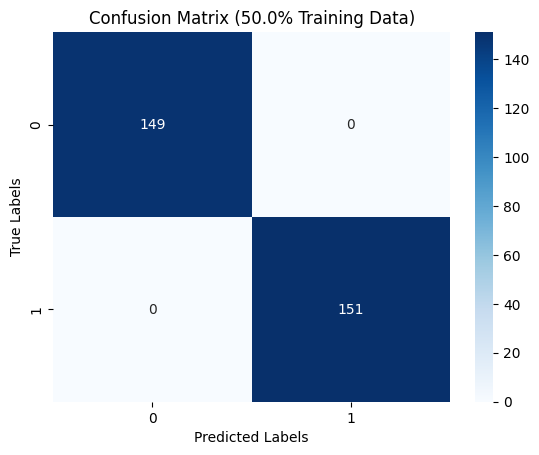

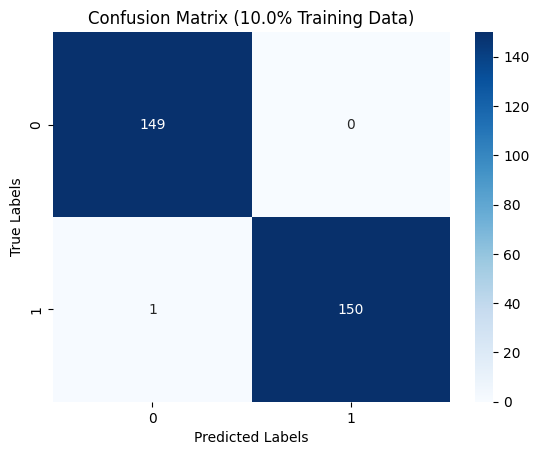

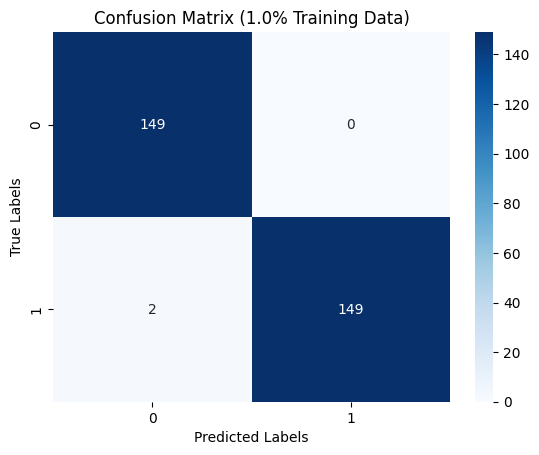

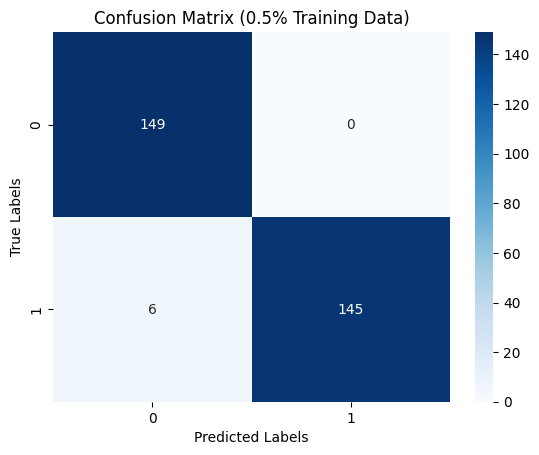

In [39]:
evaluate_con_mat(train_set, y_test, pred_SVC)

### Cost/Loss Function of SVC Model with various Training Data (hPSC-EVs vs Caco2-EVs)

In [40]:
for i, y_ts in enumerate(train_data):
    cost = log_loss(y_ts, pred_proba_SVC[i])
    print(f'SVC Cost: {cost:.10f} ({train_set[i]*100}% train)')

SVC Cost: 0.0427540529 (70.0% train)
SVC Cost: 0.0379574506 (50.0% train)
SVC Cost: 0.1038915987 (10.0% train)
SVC Cost: 0.3734327246 (1.0% train)
SVC Cost: 1.5529182777 (0.5% train)


In [41]:
del acc_SVC, pred_SVC, train_data, pred_proba_SVC, y_ts, best_params, clf_SVM, cost

## K Nearest Neighbors

### KNN Classifier without Hyperparameter Tuning (hPSC-EVs vs Caco2-EVs)

In [42]:
eval_mod=evaluate_model(KNeighborsClassifier(n_neighbors=3), train_set, X_train, y_train, X_test, y_test)

Accuracy score(KNeighborsClassifier model): 1.000000 with 70.0% training records
Accuracy score(KNeighborsClassifier model): 0.996667 with 50.0% training records
Accuracy score(KNeighborsClassifier model): 0.993333 with 10.0% training records
Accuracy score(KNeighborsClassifier model): 0.980000 with 1.0% training records
Accuracy score(KNeighborsClassifier model): 0.496667 with 0.5% training records


In [43]:
del eval_mod

In [44]:
#=======================KNN Hyperparameter Tuning=========================
clf_KNN = KNeighborsClassifier(n_neighbors=3)
param_grid = {
    'n_neighbors': [3, 5, 7, 9],  # Test different values of k
    'weights': ['uniform', 'distance'],  # Weighting function
    'metric': ['euclidean', 'manhattan']  # Distance metric
}
# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(clf_KNN, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
# Get the best parameters and best estimator
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

Best hyperparameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}


Using 700 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 300/300 [00:22<00:00, 13.32it/s]


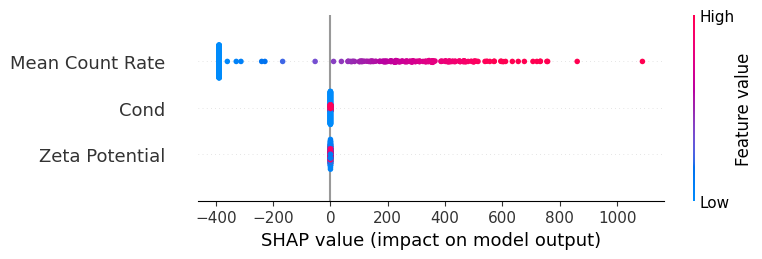

In [45]:
best_model = grid_search.best_estimator_
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)
# Create an explainer for the normalized model
explainer_norm = shap.KernelExplainer(best_model.predict_proba, X_train, nsamples=100)
shap_values_norm = explainer_norm.shap_values(X_test_norm)
shap.summary_plot(shap_values, X_test)

### KNN with Hyperparameter Tuning (hPSC-EVs vs Caco2-EVs)

In [46]:
acc_KNN, pred_KNN, train_data, pred_proba_KNN=evaluate_model(KNeighborsClassifier(n_neighbors=best_params['n_neighbors'], metric = best_params['metric'], weights = best_params['weights']), train_set, X_train, y_train, X_test, y_test)

Accuracy score(KNeighborsClassifier model): 1.000000 with 70.0% training records
Accuracy score(KNeighborsClassifier model): 0.996667 with 50.0% training records
Accuracy score(KNeighborsClassifier model): 0.996667 with 10.0% training records
Accuracy score(KNeighborsClassifier model): 0.990000 with 1.0% training records
Accuracy score(KNeighborsClassifier model): 0.966667 with 0.5% training records


### Learning Curve for KNN

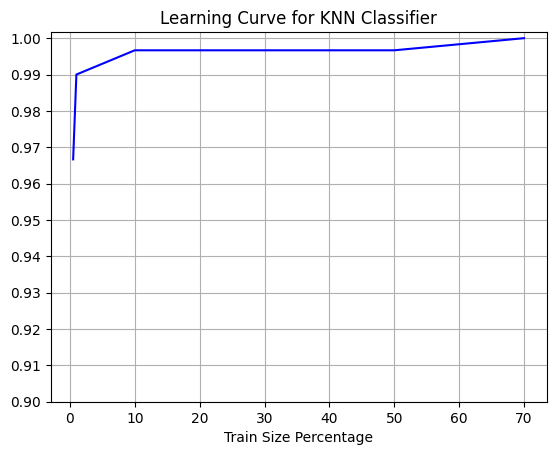

In [47]:
#===============================Learning Curve for KNN===========================================
plt.plot(training_sample,acc_KNN, color = 'b', )
plt.xticks([0,10, 20, 30, 40, 50, 60, 70])
plt.yticks([0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.0])
plt.grid()
plt.xlabel('Train Size Percentage')
plt.title('Learning Curve for KNN Classifier')
plt.show()

### ROC Curve for KNN Classifier (hPSC-EVs vs Caco2-EVs)

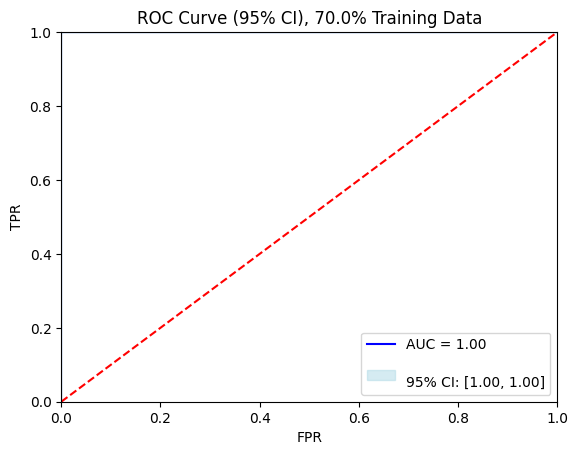

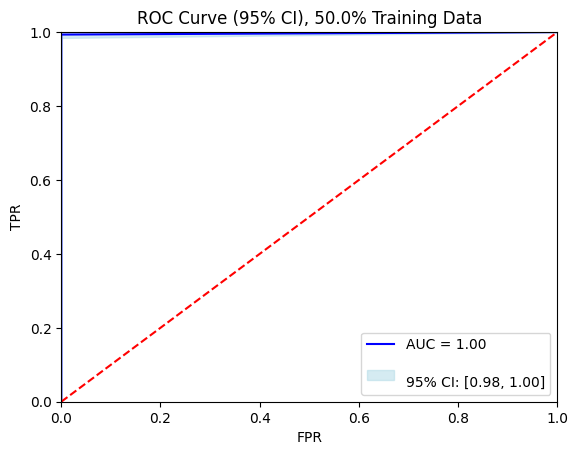

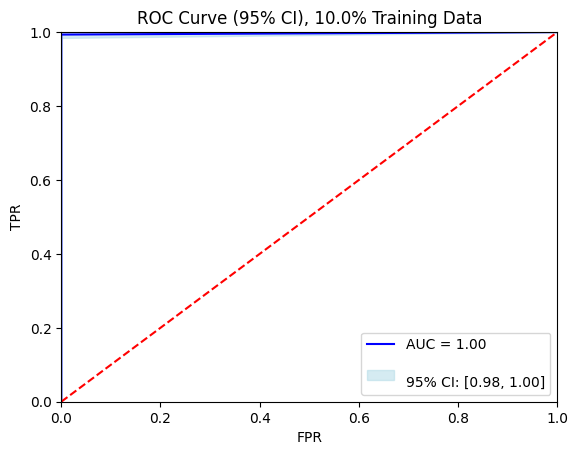

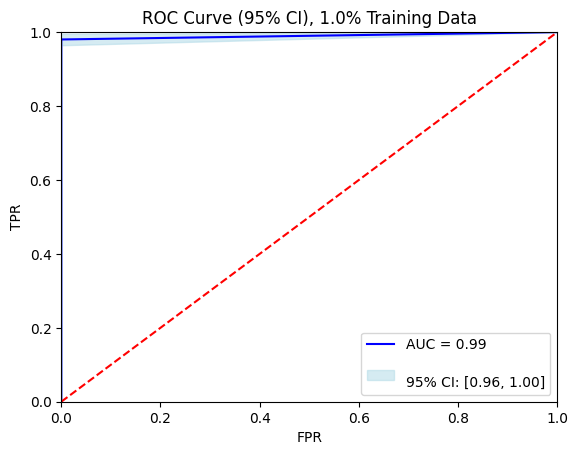

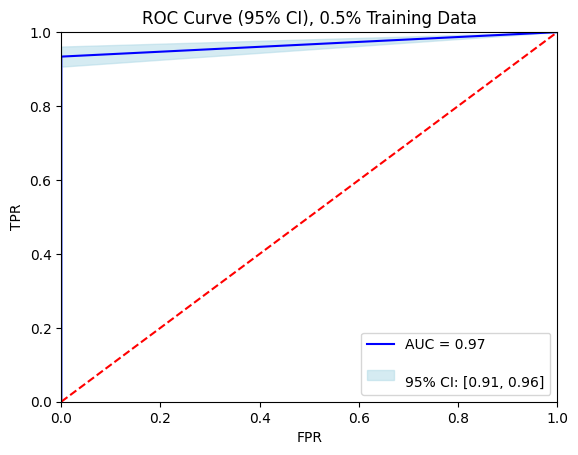

In [48]:
evaluate_ROC(train_set, y_test, pred_KNN)

### Confusion Matrix for KNN Classifier (hPSC-EVs vs Caco2-EVs)

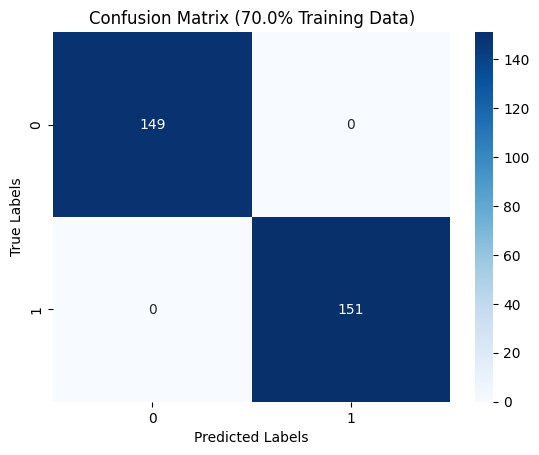

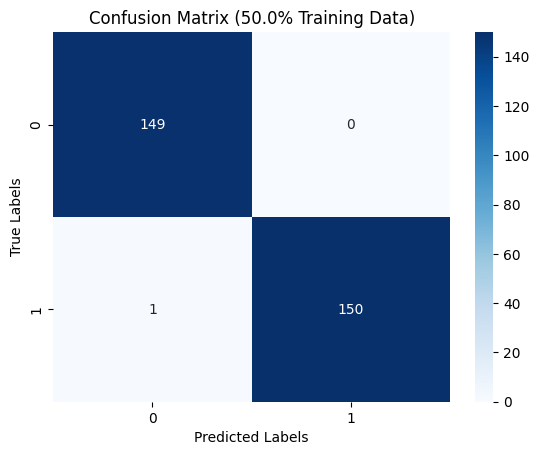

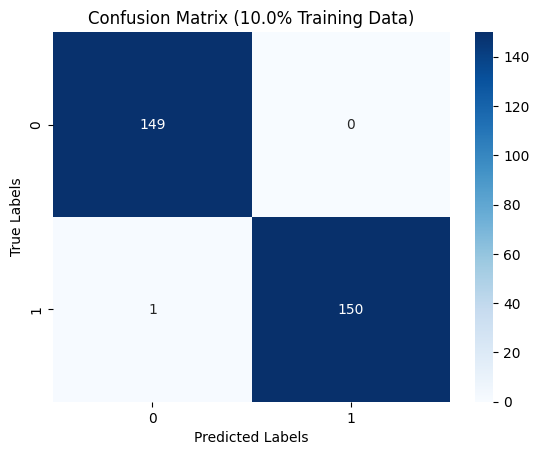

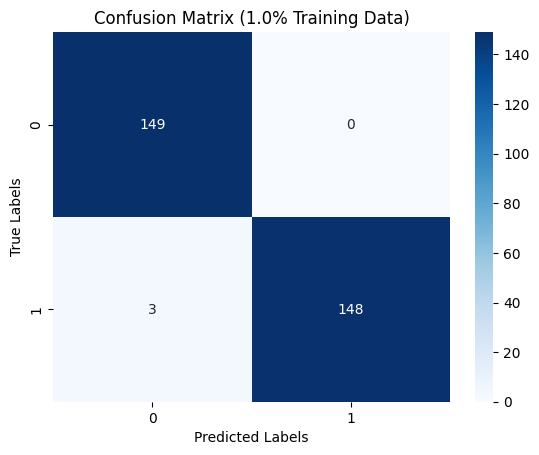

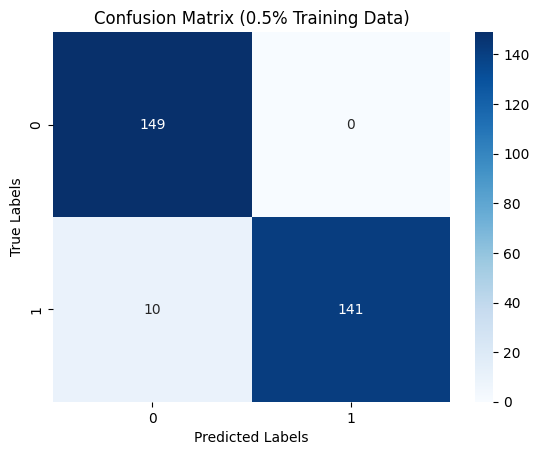

In [49]:
evaluate_con_mat(train_set, y_test, pred_KNN)

### Cost/Loss Function of KNN Model with various Training Data (hPSC-EVs vs Caco2-EVs)

In [50]:
for i, y_ts in enumerate(train_data):
    cost = log_loss(y_ts, pred_proba_KNN[i])
    print(f'KNN Cost: {cost:.10f} ({train_set[i]*100}% train)')

KNN Cost: 0.0000000000 (70.0% train)
KNN Cost: 0.0000000000 (50.0% train)
KNN Cost: 0.0000000000 (10.0% train)
KNN Cost: 0.0000000028 (1.0% train)
KNN Cost: 0.0000000133 (0.5% train)


In [51]:
del acc_KNN, pred_KNN, train_data, pred_proba_KNN, y_ts, best_params, clf_KNN, cost

## Decision Tree

### Decision Tree Classifier without Hyperparameter Tuning (hPSC-EVs vs Caco2-EVs)

In [52]:
eval_mod=evaluate_model(DecisionTreeClassifier(random_state=123), train_set, X_train, y_train, X_test, y_test)

Accuracy score(DecisionTreeClassifier model): 1.000000 with 70.0% training records
Accuracy score(DecisionTreeClassifier model): 1.000000 with 50.0% training records
Accuracy score(DecisionTreeClassifier model): 0.996667 with 10.0% training records
Accuracy score(DecisionTreeClassifier model): 0.993333 with 1.0% training records
Accuracy score(DecisionTreeClassifier model): 0.980000 with 0.5% training records


In [53]:
del eval_mod

In [54]:
clf_DT = DecisionTreeClassifier(random_state=123)
# Define the hyperparameters to tune
param_grid = {
    'criterion': ['gini', 'entropy'],  # Gini Index ar Entropy
    'max_depth': [None, 10, 20, 30],   # Maximum depth of the tree
    'min_samples_split': [2, 10, 20],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 5, 10],    # Minimum samples required at a leaf node
    'max_features': [None, 'sqrt', 'log2']  # Number of features to consider when splitting
}
grid_search = GridSearchCV(estimator=clf_DT, param_grid=param_grid, cv=5, scoring='accuracy')
# Fitting the training data
grid_search.fit(X_train, y_train)
# Storing the best parameters used to improve the accuracy
best_params = grid_search.best_params_
print("Best Parameters:",best_params)

Best Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


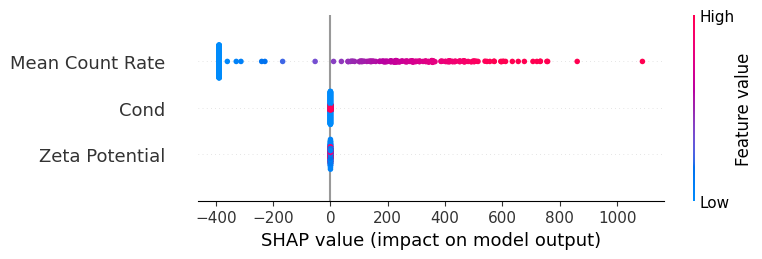

In [56]:
best_model = grid_search.best_estimator_
# Create an explainer
explainer =  shap.TreeExplainer(best_model)
shap.summary_plot(shap_values, X_test)

### Decision Tree Classifier with Hyperparameter Tuning (hPSC-EVs vs Caco2-EVs)

In [57]:
acc_DT, pred_DT, train_data, pred_proba_DT = evaluate_model(DecisionTreeClassifier(criterion = best_params['criterion'], max_depth = best_params['max_depth'], max_features = best_params['max_features'], min_samples_leaf = best_params['min_samples_leaf'], min_samples_split = best_params['min_samples_split']), train_set, X_train, y_train, X_test, y_test)

Accuracy score(DecisionTreeClassifier model): 1.000000 with 70.0% training records
Accuracy score(DecisionTreeClassifier model): 1.000000 with 50.0% training records
Accuracy score(DecisionTreeClassifier model): 0.996667 with 10.0% training records
Accuracy score(DecisionTreeClassifier model): 1.000000 with 1.0% training records
Accuracy score(DecisionTreeClassifier model): 1.000000 with 0.5% training records


### Learning Curve for Decision Tree

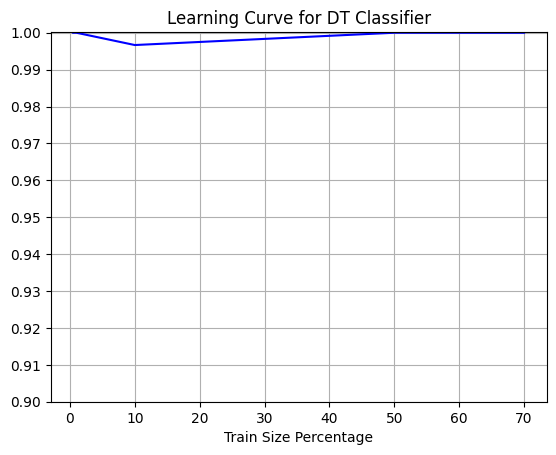

In [58]:
#===============================Learning Curve for DT===========================================
plt.plot(training_sample,acc_DT, color = 'b', )
plt.xticks([0,10, 20, 30, 40, 50, 60, 70])
plt.yticks([0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.0])
plt.grid()
plt.xlabel('Train Size Percentage')
plt.title('Learning Curve for DT Classifier')
plt.show()

### ROC Curve for Decision Tree Classifier (hPSC-EVs vs Caco2-EVs)

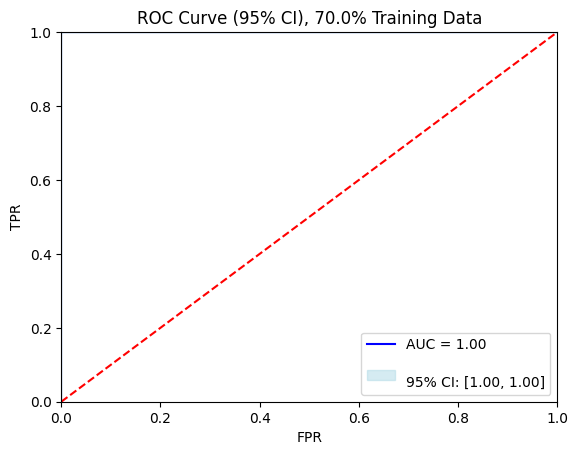

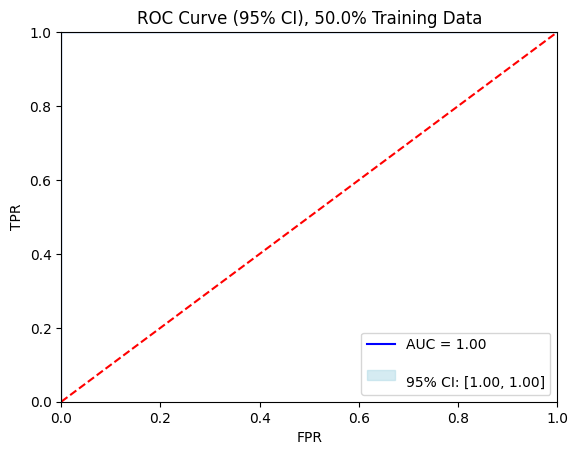

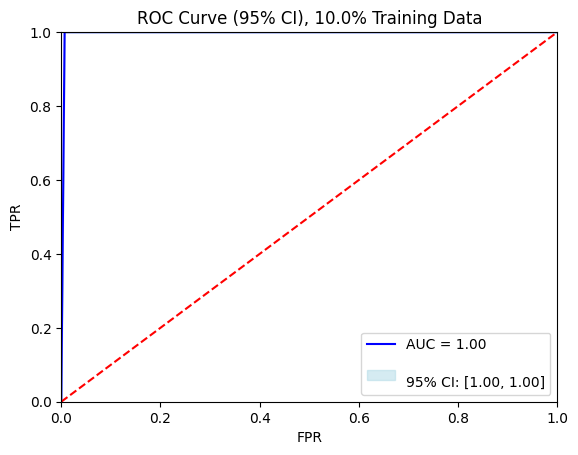

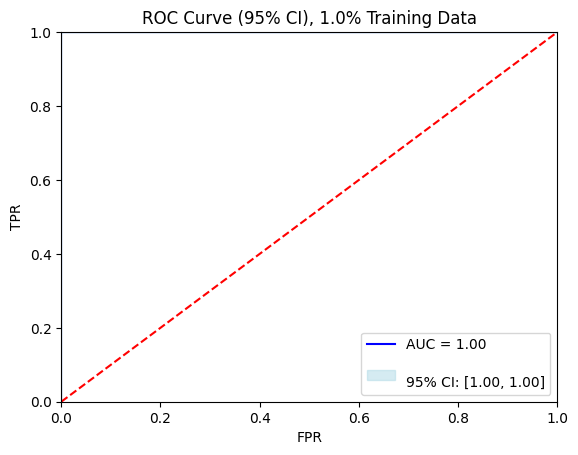

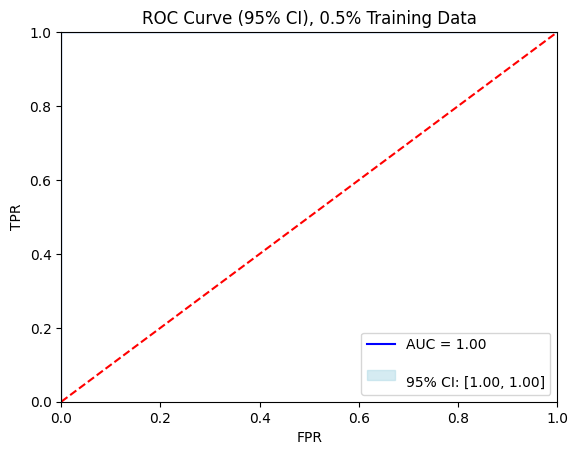

In [59]:
evaluate_ROC(train_set, y_test, pred_DT)

### Confusion Matrix for Decision Tree Classifier (hPSC-EVs vs Caco2-EVs)

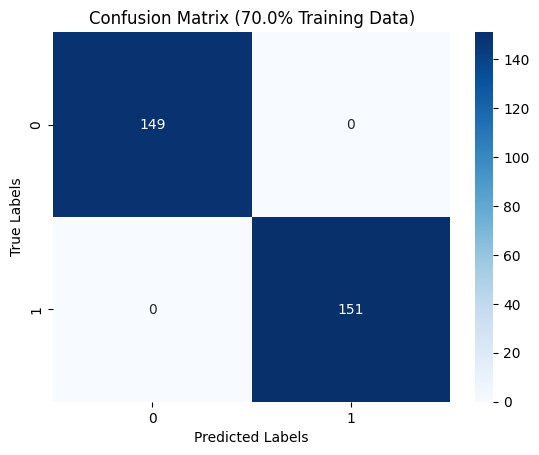

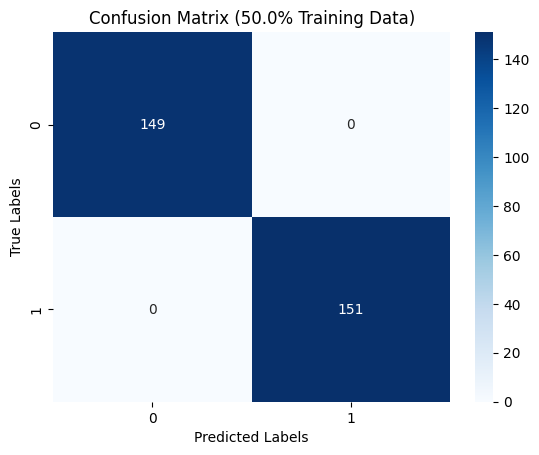

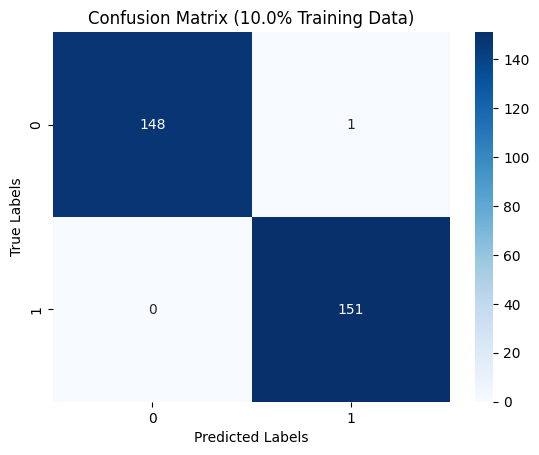

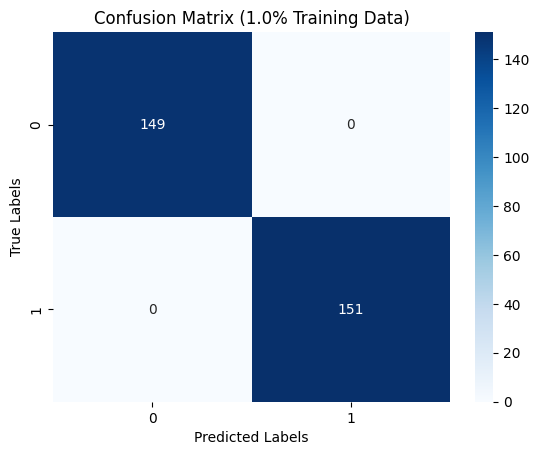

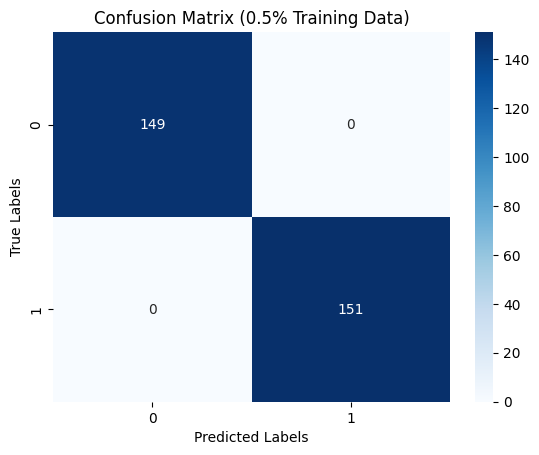

In [60]:
evaluate_con_mat(train_set, y_test, pred_DT)

### Cost/Loss Function of DT Model with various Training Data (hPSC-EVs vs Caco2-EVs)

In [61]:
for i, y_ts in enumerate(train_data):
    cost = log_loss(y_ts, pred_proba_DT[i])
    print(f'DT Cost: {cost:.10f} ({train_set[i]*100}% train)')

DT Cost: 0.0000000000 (70.0% train)
DT Cost: 0.0000000000 (50.0% train)
DT Cost: 0.0000000000 (10.0% train)
DT Cost: 0.0000000000 (1.0% train)
DT Cost: 0.0000000000 (0.5% train)


In [62]:
del acc_DT, pred_DT, train_data, pred_proba_DT, y_ts, best_params, clf_DT, cost

## XGBoost Classifier

### XGBoost Classifier without Hyperparameter Tuning (hPSC-EVs vs Caco2-EVs)

In [57]:
eval_mod=evaluate_model(xgb.XGBClassifier( eval_metric='mlogloss'), train_set, X_train, y_train, X_test, y_test)

Accuracy score(XGBClassifier model): 1.000000 with 70.0% training records
Accuracy score(XGBClassifier model): 1.000000 with 50.0% training records
Accuracy score(XGBClassifier model): 0.993333 with 10.0% training records
Accuracy score(XGBClassifier model): 0.496667 with 1.0% training records
Accuracy score(XGBClassifier model): 0.496667 with 0.5% training records


In [58]:
del eval_mod

In [22]:
#=============================Hyperparameter Tuning==============================
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
xgb_clf=xgb.XGBClassifier( eval_metric='mlogloss')
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'min_child_weight': [1, 5],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8],
    'gamma': [0, 0.1]
}
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, 
                           scoring='accuracy', cv=3, verbose=0, n_jobs=-1)
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
# Storing the best parameters used to improve the accuracy
best_params = grid_search.best_params_
print("Best Parameters:",best_params)

Best Parameters: {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.6}


### XGBoost Classifier with Hyperparameter Tuning (hPSC-EVs vs Caco2-EVs)

In [60]:
xgb_clf=xgb.XGBClassifier(colsample_bytree=best_params['colsample_bytree'], gamma=best_params['gamma'], 
                          learning_rate=best_params['learning_rate'], max_depth=best_params['max_depth'],
                          min_child_weight=best_params['min_child_weight'], n_estimators=best_params['n_estimators'],
                          subsample=best_params['subsample'])
acc_XGB, pred_XGB, train_data, pred_proba_XGB = evaluate_model(xgb_clf, train_set, X_train, y_train, X_test, y_test)

Accuracy score(XGBClassifier model): 1.000000 with 70.0% training records
Accuracy score(XGBClassifier model): 1.000000 with 50.0% training records
Accuracy score(XGBClassifier model): 1.000000 with 10.0% training records
Accuracy score(XGBClassifier model): 0.496667 with 1.0% training records
Accuracy score(XGBClassifier model): 0.496667 with 0.5% training records


### Learning Curve for XGBoost Classifier

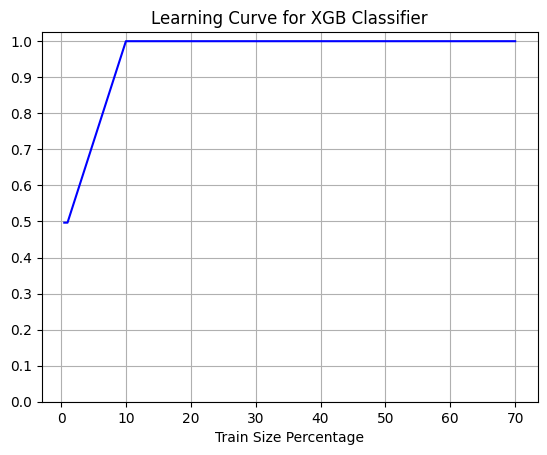

In [61]:
#===============================Learning Curve for XGB===========================================
plt.plot(training_sample,acc_XGB, color = 'b', )
plt.xticks([0,10, 20, 30, 40, 50, 60, 70])
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.grid()
plt.xlabel('Train Size Percentage')
plt.title('Learning Curve for XGB Classifier')
plt.show()

### ROC Curve for XGBoost Classifier (hPSC-EVs vs Caco2-EVs)

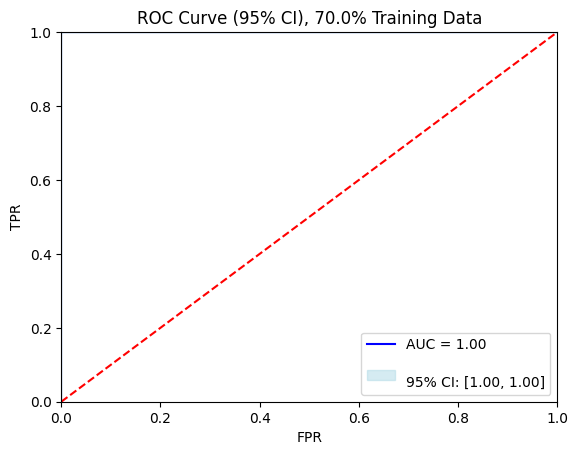

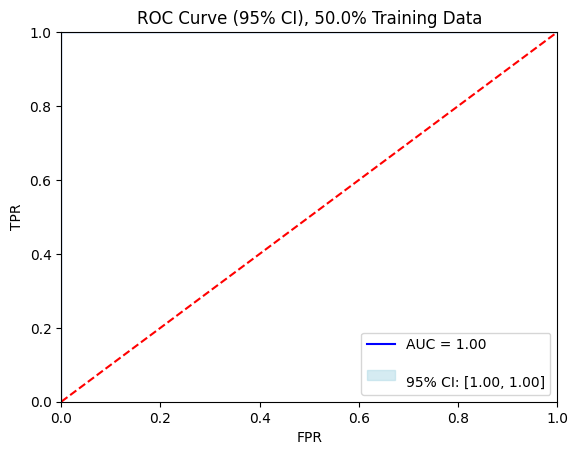

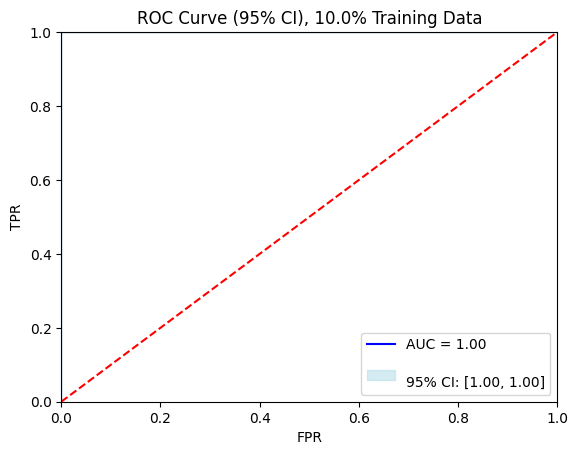

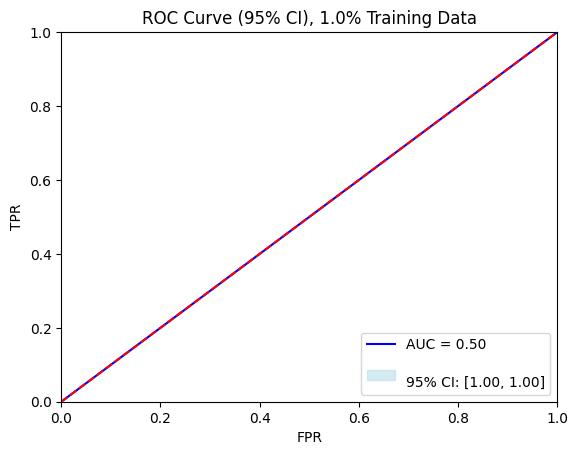

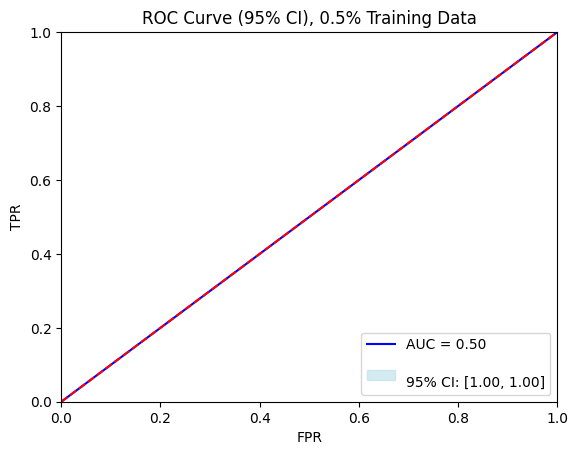

In [62]:
evaluate_ROC(train_set, y_test, pred_XGB)

### Confusion Matrix for XGBoost Classifier (hPSC-EVs vs Caco2-EVs)

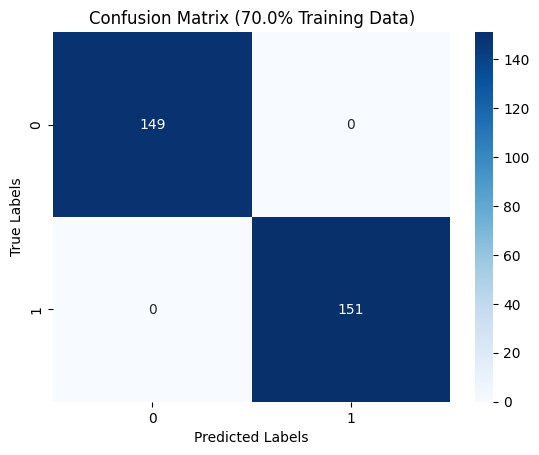

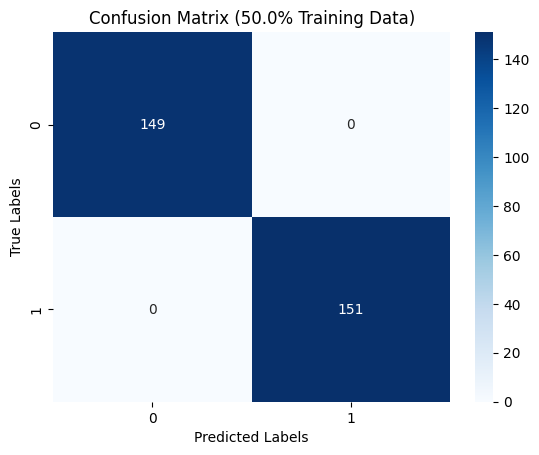

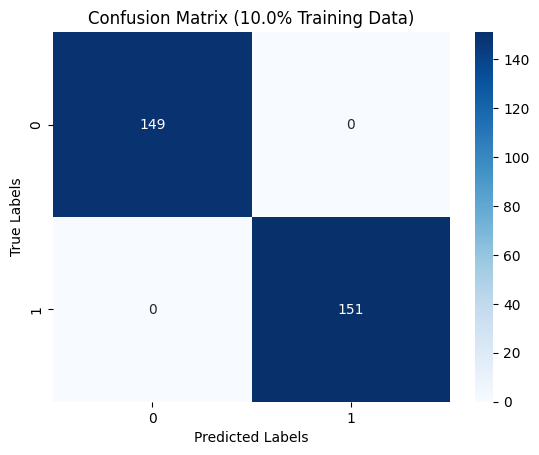

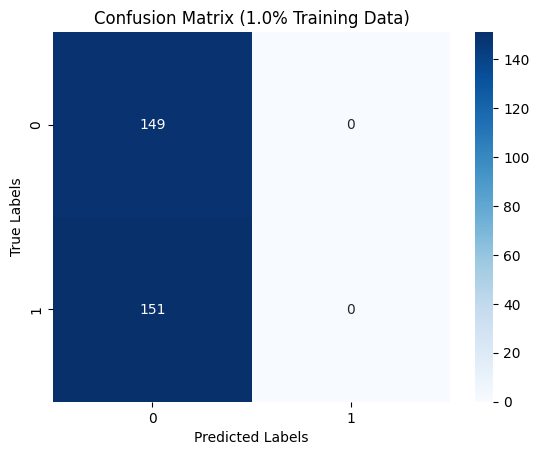

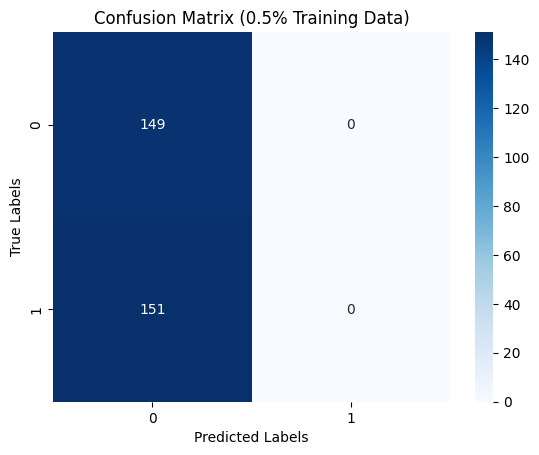

In [63]:
evaluate_con_mat(train_set, y_test, pred_XGB)

### Cost/Loss Function of XGB Model with various Training Data (hPSC-EVs vs Caco2-EVs)

In [64]:
for i, y_ts in enumerate(train_data):
    cost = log_loss(y_ts, pred_proba_XGB[i])
    print(f'XGB Cost: {cost:.10f} ({train_set[i]*100}% train)')

XGB Cost: 0.2102837319 (70.0% train)
XGB Cost: 0.2124374079 (50.0% train)
XGB Cost: 0.2497641826 (10.0% train)
XGB Cost: 0.5991880637 (1.0% train)
XGB Cost: 0.6365923389 (0.5% train)


In [65]:
del acc_XGB, pred_XGB, train_data, pred_proba_XGB, y_ts, best_params, xgb_clf, cost

# Vector Quantum Classifier

In [21]:
from qiskit_algorithms.utils import algorithm_globals
from qiskit.circuit.library import EfficientSU2, ZZFeatureMap
import qiskit_algorithms.optimizers as op
from qiskit.primitives import Sampler
from qiskit_machine_learning.algorithms.classifiers import VQC

In [22]:
train_features = MinMaxScaler().fit_transform(X_train)
train_labels = y_train
test_features = MinMaxScaler().fit_transform(X_test)
test_labels = y_test
num_features = train_features.shape[1]
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)

In [88]:
del X_train, y_train

In [23]:
ansatz = EfficientSU2(num_qubits=num_features, reps=3)

In [24]:
optimizer = op.COBYLA(maxiter=400)

In [25]:
sampler = Sampler()

### Vector Quantum Classifier with Hyperparameter Tuning (hPSC-EVs vs Caco2-EVs)

In [26]:
#======================================VQC=================================================
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    loss = 'squared_error',
    optimizer=optimizer
)
acc_vqtask1 = []
pred_vqtask1 = []
for elm in train_set:
    X_t, dummy_x, y_t, dummy_y = train_test_split(train_features, train_labels, train_size=elm, random_state=123)
    vqc.fit(X_t, y_t.values)
    pred = vqc.predict(test_features)
    accuracy = accuracy_score(test_labels.values, pred)
    pred_vqtask1.append(pred)
    acc_vqtask1.append(accuracy)
    print(f'Accuracy score(VQC Model): {accuracy} with {elm*100}% training records')
#======================================VQC=================================================

Accuracy score(VQC Model): 1.0 with 70.0% training records
Accuracy score(VQC Model): 0.9966666666666667 with 50.0% training records
Accuracy score(VQC Model): 0.9933333333333333 with 10.0% training records
Accuracy score(VQC Model): 0.9633333333333334 with 1.0% training records
Accuracy score(VQC Model): 0.9966666666666667 with 0.5% training records


### Learning Curve for VQC

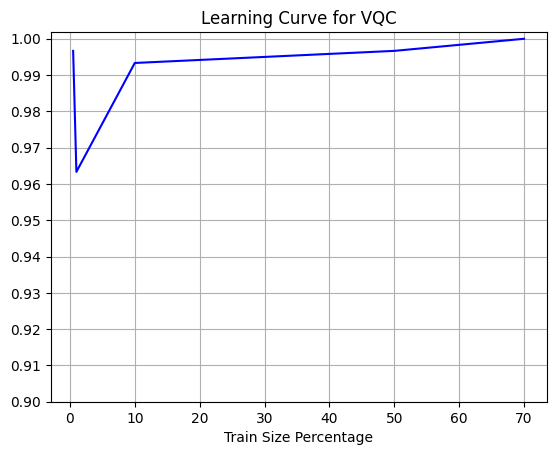

In [27]:
#===============================Learning Curve for VQC===========================================
plt.plot(training_sample,acc_vqtask1, color = 'b', )
plt.xticks([0,10, 20, 30, 40, 50, 60, 70])
plt.yticks([0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.0])
plt.grid()
plt.xlabel('Train Size Percentage')
plt.title('Learning Curve for VQC')
plt.show()

### 3D Scatter Plot for VQC Model (hPSC-EVs vs Caco2-EVs)

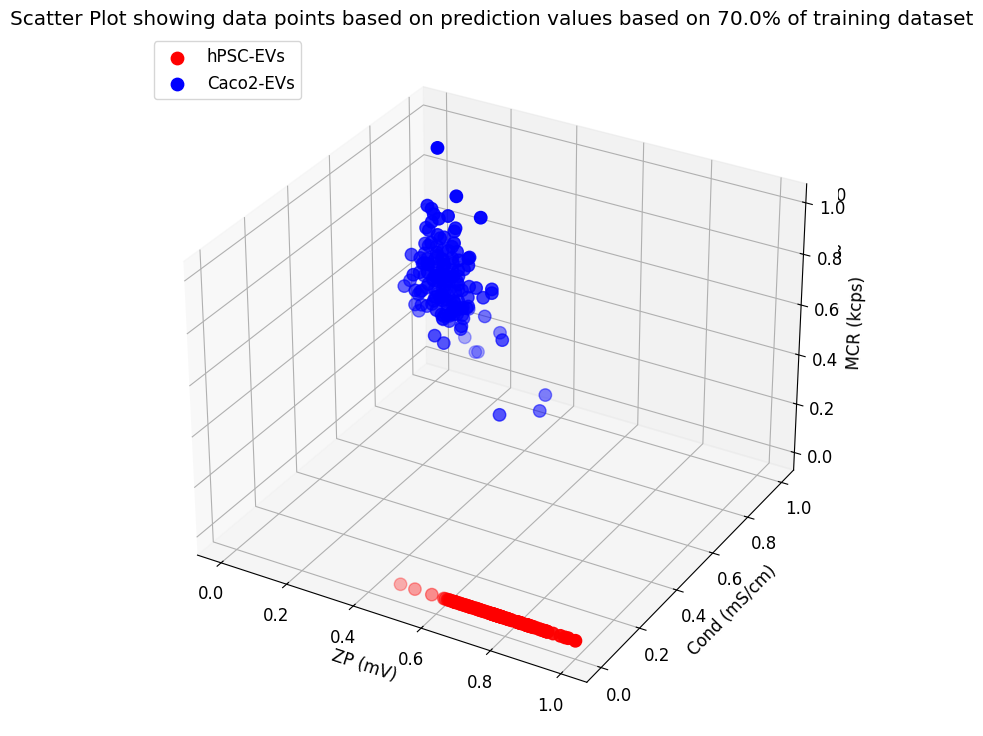

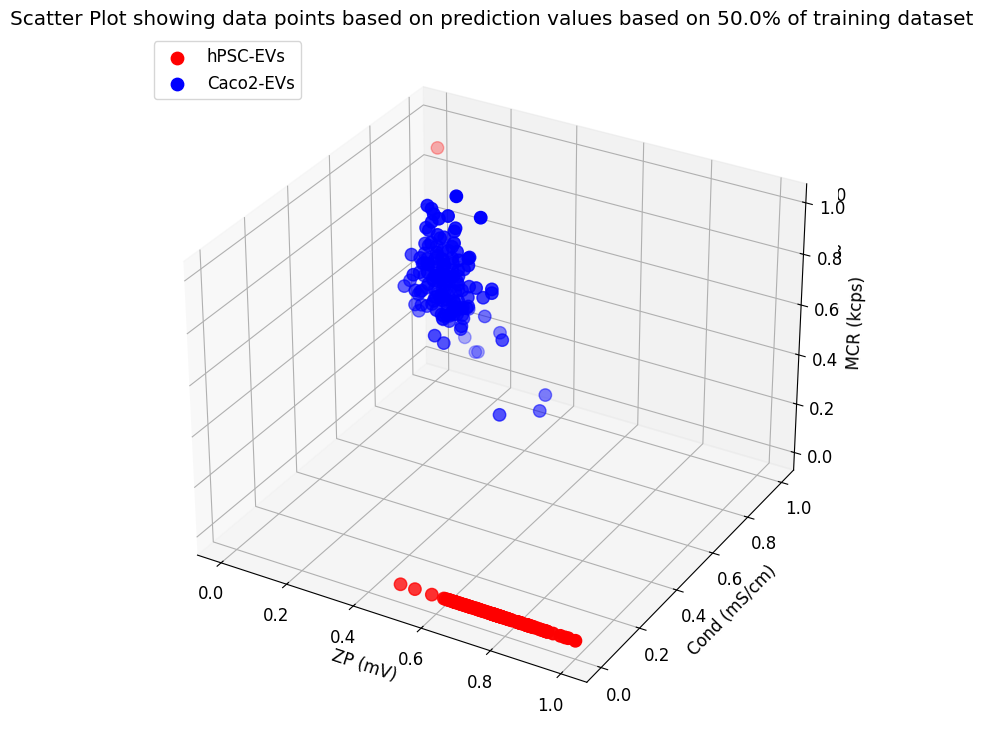

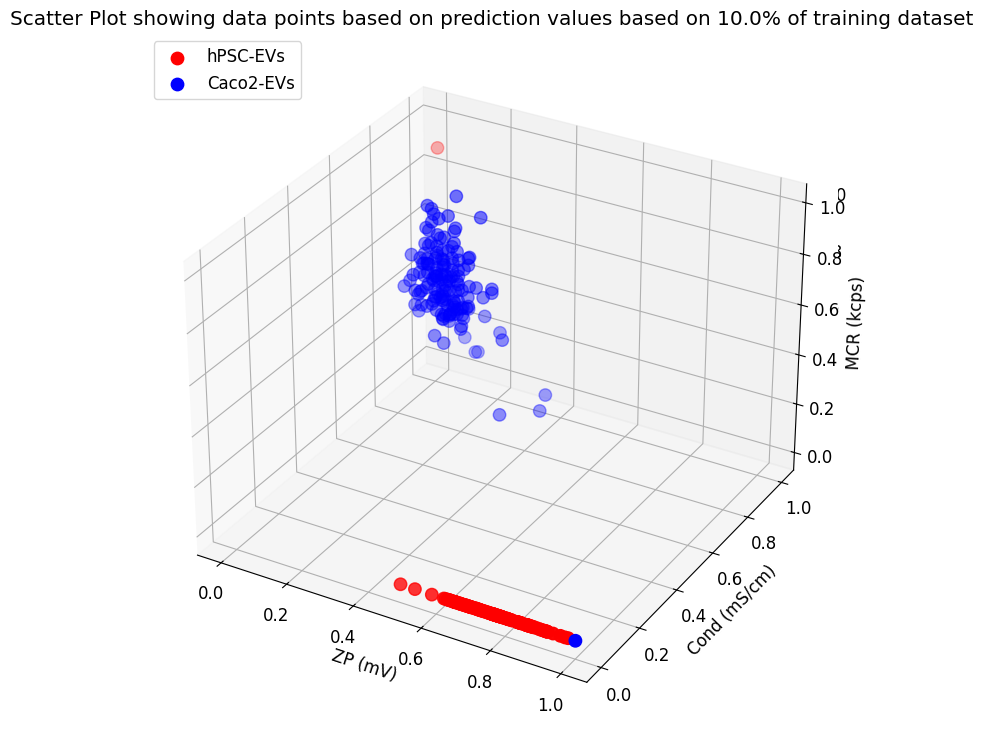

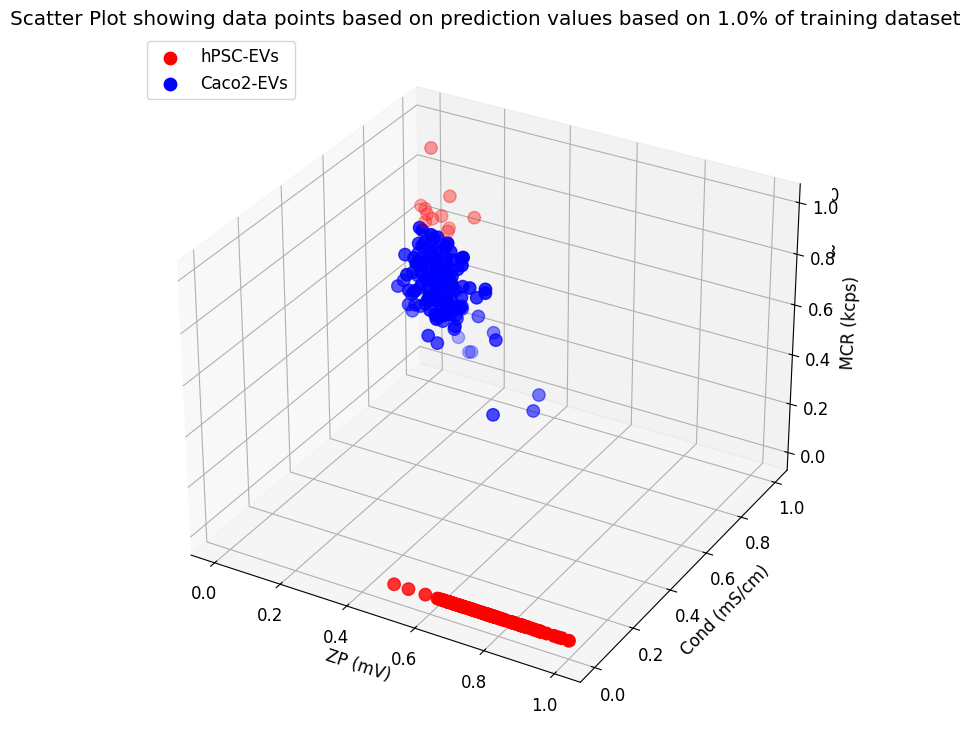

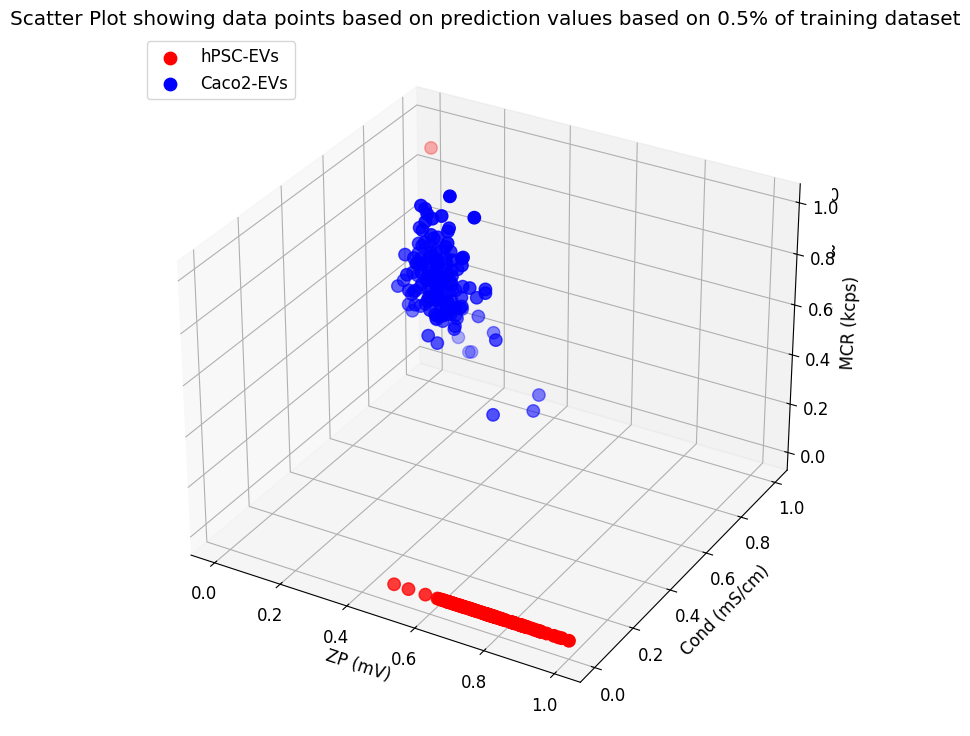

In [28]:
#=======================================3D Scatter Plot===============================
for i in range(len(train_set)):
    plt.rcParams.update({'font.size': 12})
    fig = plt.figure(figsize=(9,9))
    ax = plt.subplot(1,1,1,projection='3d')
    ax = fig.add_subplot(111,projection='3d')
    ax.scatter(test_features[pred_vqtask1[i]==0,0], test_features[pred_vqtask1[i]==0,1], test_features[pred_vqtask1[i]==0,2], c='red', marker='o', label='hPSC-EVs', s=80)
    ax.scatter(test_features[pred_vqtask1[i]==1,0], test_features[pred_vqtask1[i]==1,1], test_features[pred_vqtask1[i]==1,2], c='blue', marker='o', label='Caco2-EVs',s=80)
    # Set labels for each axis
    ax.set_xlabel('ZP (mV)')
    ax.set_ylabel('Cond (mS/cm)')
    ax.set_zlabel('MCR (kcps)')
    ax.set_title(f'Scatter Plot showing data points based on prediction values based on {train_set[i]*100}% of training dataset')
    ax.tick_params("z", which="major",length=15,width = 2.0)
    ax.legend(loc='upper left')
    plt.show()

### ROC Curve for Vector Quantum Classifier (hPSC-EVs vs Caco2-EVs)

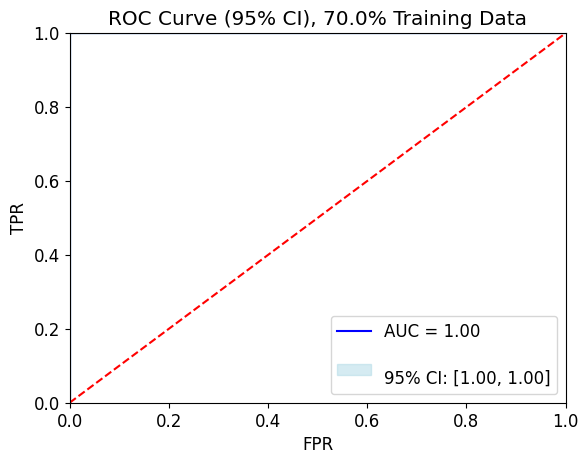

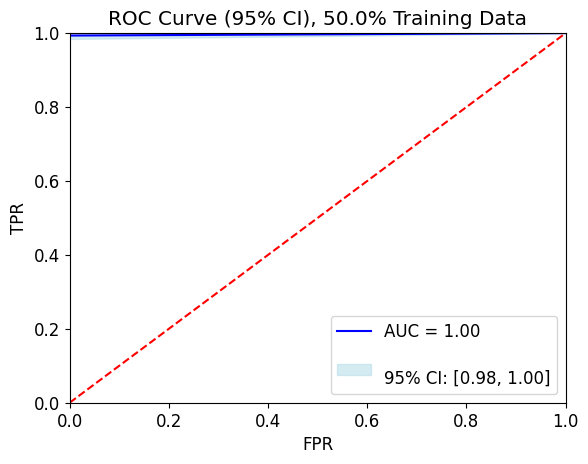

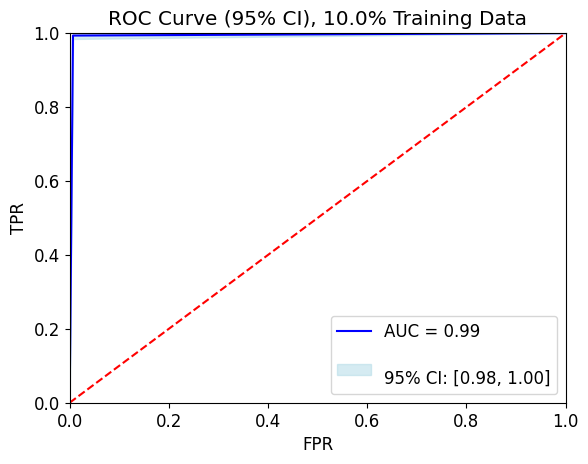

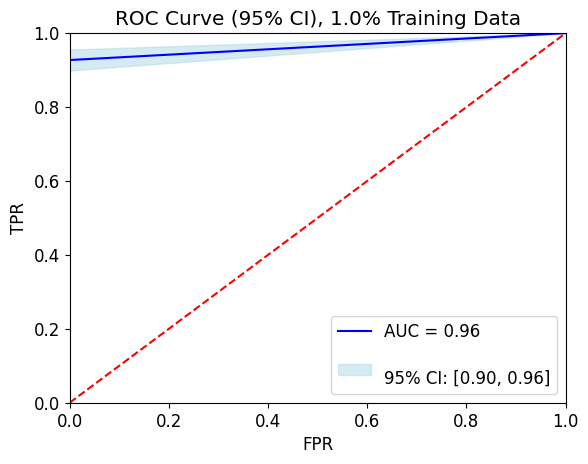

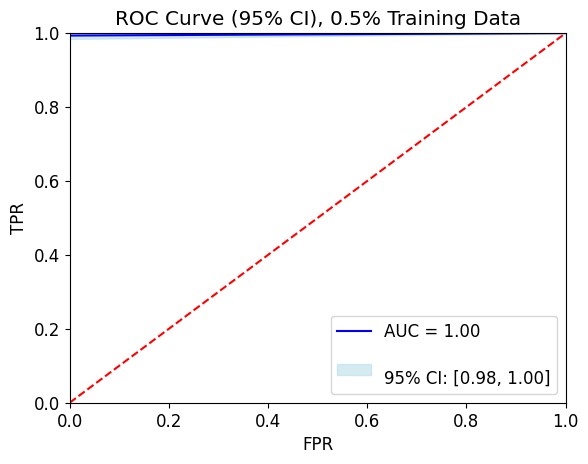

In [29]:
evaluate_ROC(train_set, test_labels, pred_vqtask1)

### Confusion Matrix for Vector Quantum Classifier (hPSC-EVs vs Caco2-EVs)

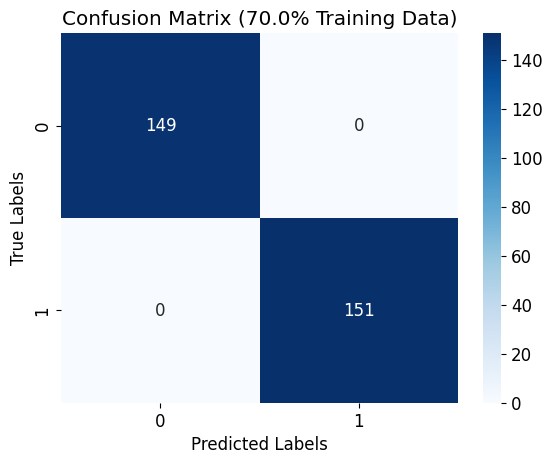

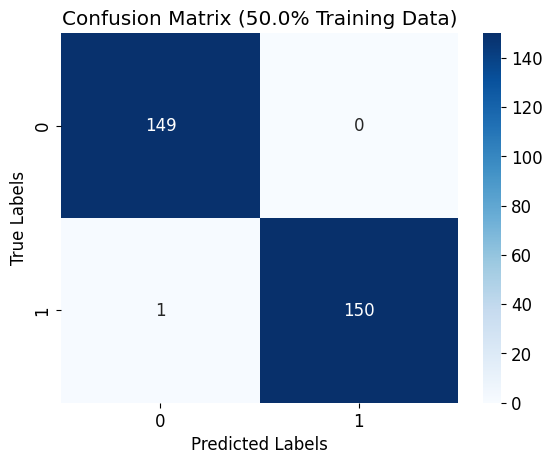

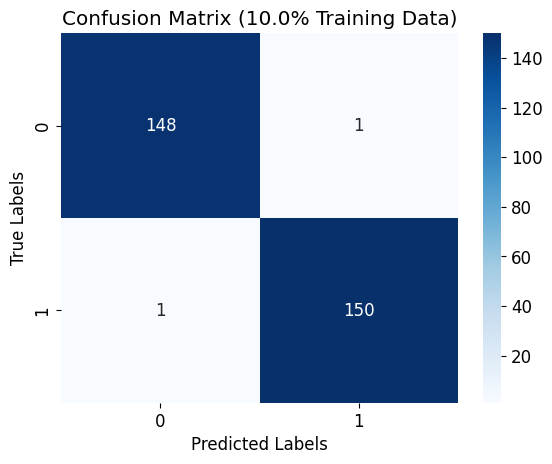

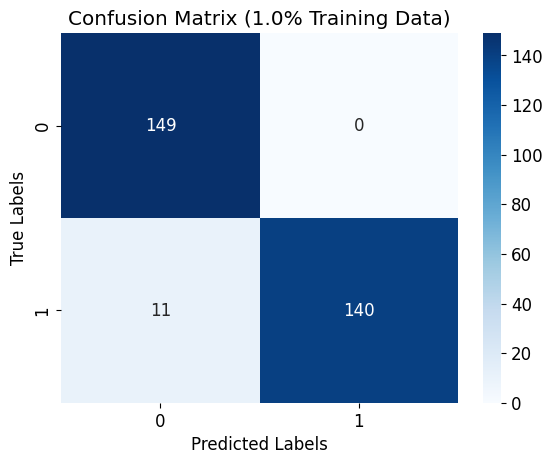

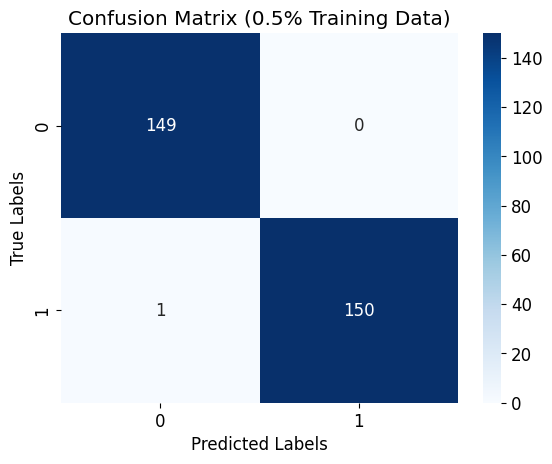

In [30]:
evaluate_con_mat(train_set, test_labels, pred_vqtask1)

In [31]:
del train_features, train_labels, test_features, test_labels, num_features, pred_vqtask1, acc_vqtask1

# <center>hPSC-EVs vs DLD-1-EVs</center>

In [63]:
#==================Predictor Variables=====================================
X2 = dataset2[['Zeta Potential', 'Cond', 'Mean Count Rate']]
#X = dataset.drop(['Grade','Age_in_years'], axis = 1)
#===================Output Variable========================================
y2 = dataset2['Sample Name']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=123)

## Logistic Regression

### Logistic Regression without Hyperparameter Tuning (hPSC-EVs vs DLD-1-EVs)

In [64]:
eval_mod=evaluate_model(LogisticRegression(solver = 'lbfgs', max_iter=1000), train_set, X_train2, y_train2, X_test2, y_test2)

Accuracy score(LogisticRegression model): 1.000000 with 70.0% training records
Accuracy score(LogisticRegression model): 1.000000 with 50.0% training records
Accuracy score(LogisticRegression model): 1.000000 with 10.0% training records
Accuracy score(LogisticRegression model): 0.986667 with 1.0% training records
Accuracy score(LogisticRegression model): 0.933333 with 0.5% training records


In [65]:
del eval_mod

In [66]:
#===============================Hyperparameter Tuning================================
from sklearn.exceptions import ConvergenceWarning
# Supressing Warning related to convergence
warnings.filterwarnings("ignore", category=ConvergenceWarning)

clf_LR = LogisticRegression(solver = 'lbfgs', max_iter=1000)
param_grid = { 'C': [0.001, 0.01, 0.1, 1, 10, 100],'penalty': ['l2'], 'solver': ['newton-cg','lbfgs' ,'liblinear', 'saga']}
grid_search = GridSearchCV(clf_LR, param_grid, cv=10, verbose=0 ,scoring='accuracy')
grid_search.fit(X_train2, y_train2)
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

Best hyperparameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}


In [67]:
best_model = grid_search.best_estimator_
# Use SHAP's LinearExplainer with the best model
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    explainer = shap.LinearExplainer(best_model, X_train2, feature_perturbation="interventional")
    shap_values = explainer.shap_values(X_test2)

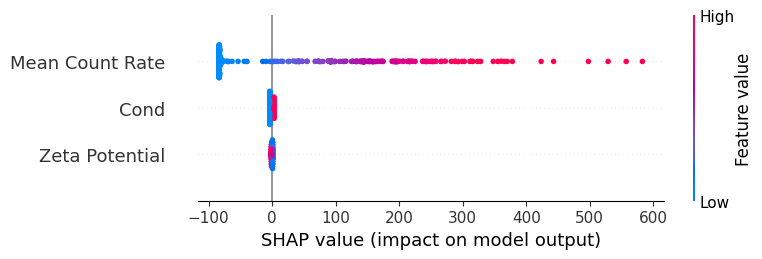

In [68]:
shap.summary_plot(shap_values,X_test2)

### Logistic Regression Model with Hyperparameter Tuning (hPSC-EVs vs DLD-1-EVs)

In [69]:
#==============================Logistic Regression Model with Hyperparameter Tuning===========================
acc_LR, pred_LR, train_data, pred_proba_LR = evaluate_model(LogisticRegression(solver = best_params['solver'], penalty=best_params['penalty'], C = best_params['C']), train_set, X_train2, y_train2, X_test2, y_test2)

Accuracy score(LogisticRegression model): 1.000000 with 70.0% training records
Accuracy score(LogisticRegression model): 1.000000 with 50.0% training records
Accuracy score(LogisticRegression model): 1.000000 with 10.0% training records
Accuracy score(LogisticRegression model): 0.980000 with 1.0% training records
Accuracy score(LogisticRegression model): 0.933333 with 0.5% training records


### Accuracy Curve for Logistic Regression

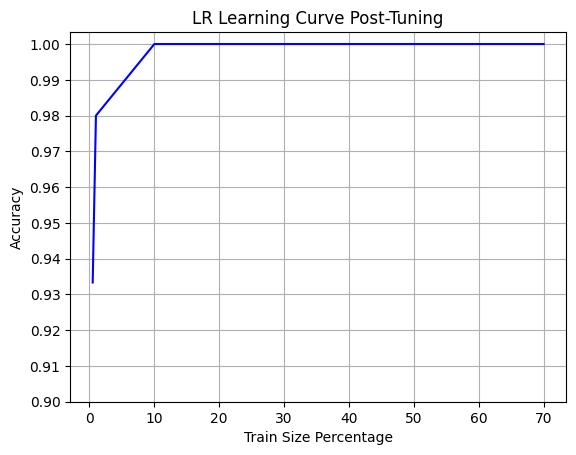

In [70]:
#===============================Learning Curve for LR===========================================
plt.plot(training_sample,acc_LR, color = 'b', )
plt.xticks([0,10, 20, 30, 40, 50, 60, 70])
plt.yticks([0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.0])
plt.grid()
plt.xlabel('Train Size Percentage')
plt.ylabel('Accuracy')
plt.title('LR Learning Curve Post-Tuning')
plt.show()

### ROC Curve for Logistic Regression (hPSC-EVs vs DLD-1-EVs)

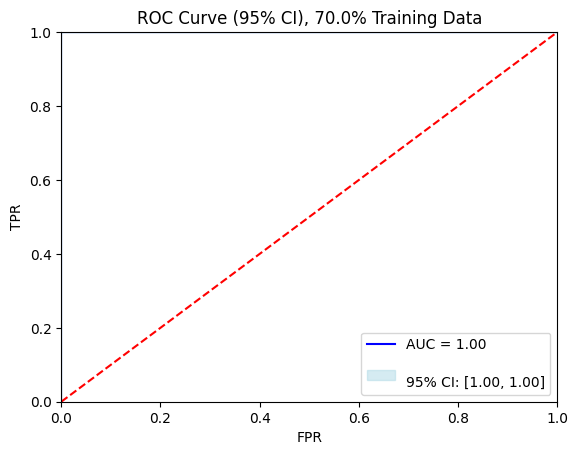

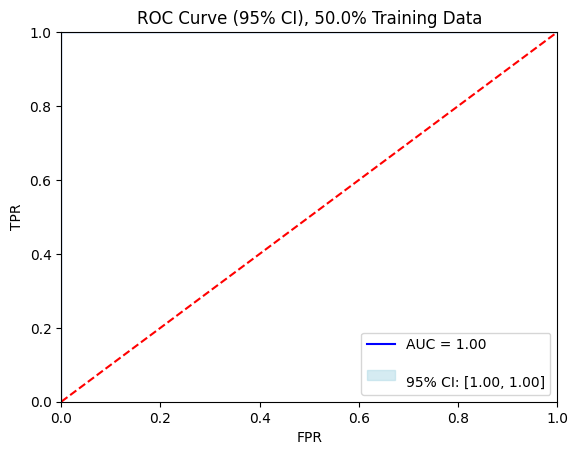

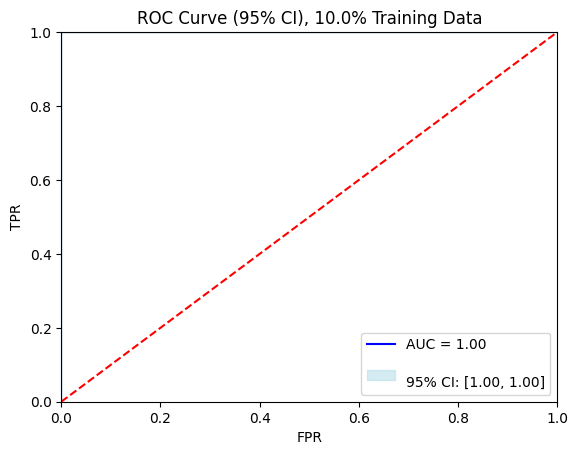

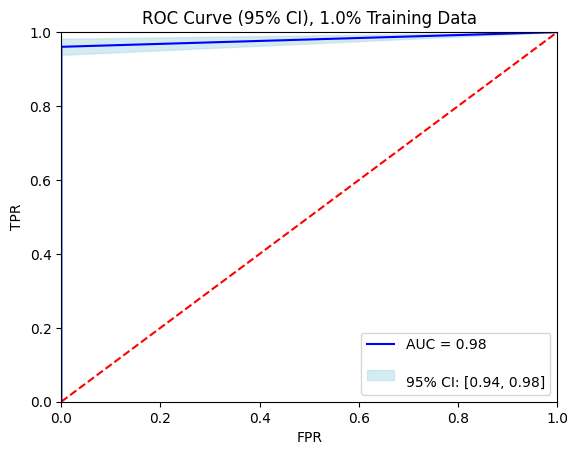

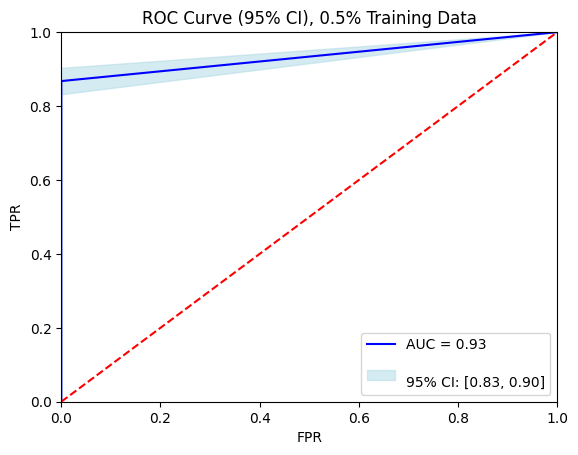

In [71]:
evaluate_ROC(train_set, y_test2, pred_LR)

### Confusion Matrix for Logistic Regression (hPSC-EVs vs DLD-1-EVs)

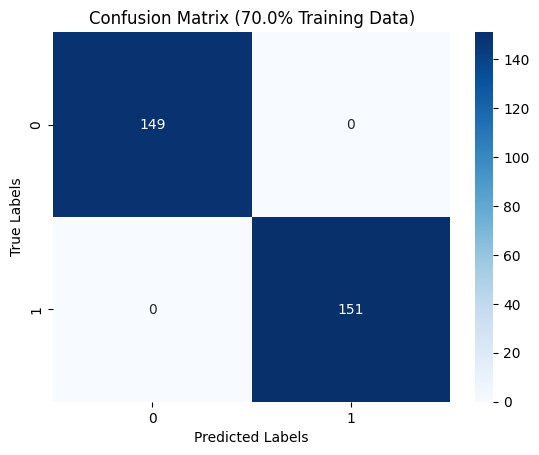

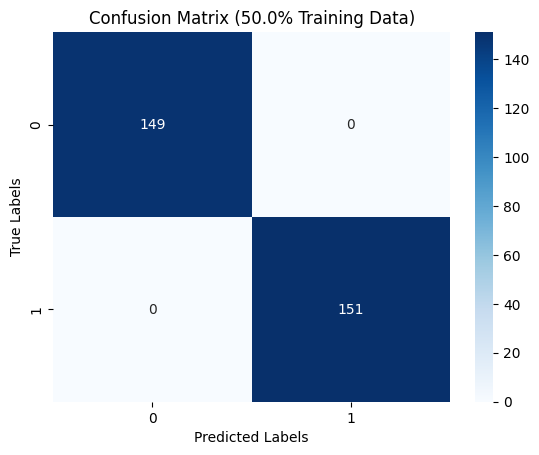

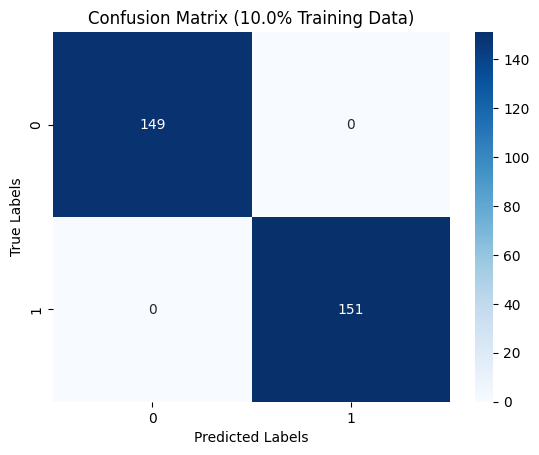

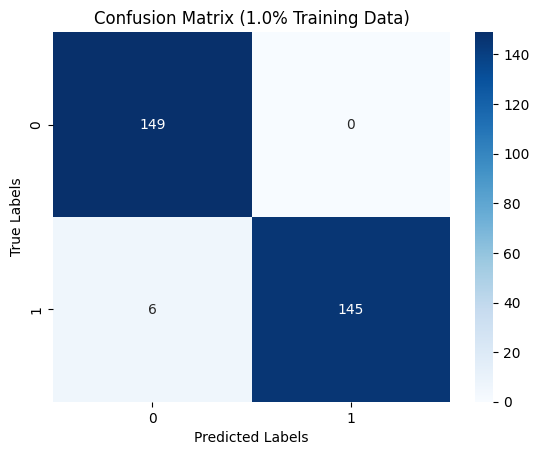

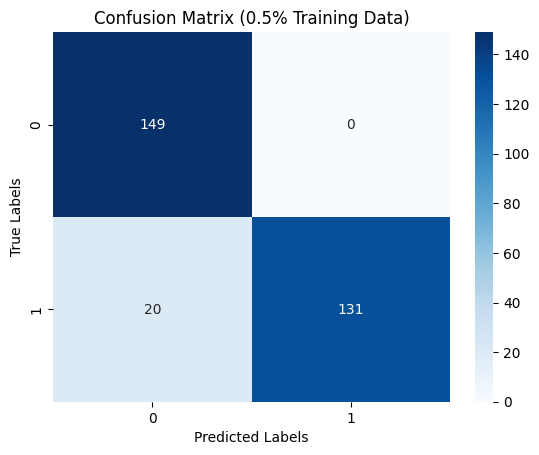

In [72]:
evaluate_con_mat(train_set, y_test2, pred_LR)

### Cost/Loss Function of Logistic Regression Model with various Training Data (hPSC-EVs vs DLD-1-EVs)

In [73]:
for i, y_t in enumerate(train_data):
    cost = log_loss(y_t, pred_proba_LR[i])
    print(f'LR Cost: {cost:.10f} ({train_set[i]*100}% train)')

LR Cost: 0.0058827637 (70.0% train)
LR Cost: 0.0077374649 (50.0% train)
LR Cost: 0.0242675342 (10.0% train)
LR Cost: 0.0595343896 (1.0% train)
LR Cost: 0.0045922184 (0.5% train)


In [74]:
del acc_LR, pred_LR, train_data, pred_proba_LR, y_t, best_params, clf_LR, cost

## Support Vector Classifier

### Support Vector Classifier without Hyperparameter Tuning (hPSC-EVs vs DLD-1-EVs)

In [75]:
eval_mod=evaluate_model(SVC(probability=True), train_set, X_train2, y_train2, X_test2, y_test2)

Accuracy score(SVC model): 0.933333 with 70.0% training records
Accuracy score(SVC model): 0.933333 with 50.0% training records
Accuracy score(SVC model): 0.923333 with 10.0% training records
Accuracy score(SVC model): 0.936667 with 1.0% training records
Accuracy score(SVC model): 0.520000 with 0.5% training records


In [76]:
del eval_mod

In [77]:
#==========================Hyperparameter Tuning==========================
clf_SVM = SVC(probability=True)
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel type
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],  # Kernel coefficient
}
grid_search = GridSearchCV(estimator=clf_SVM, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train2, y_train2)
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

Best hyperparameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


Using 700 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 300/300 [00:21<00:00, 13.98it/s]


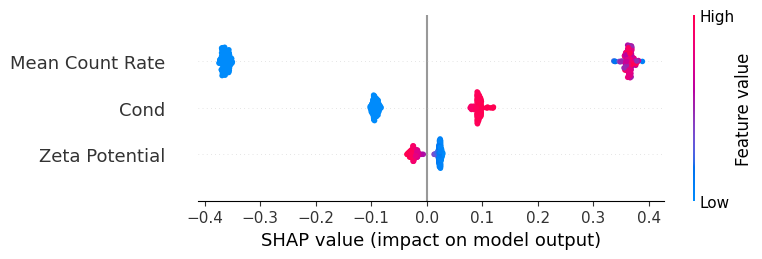

In [78]:
best_model = grid_search.best_estimator_
explainer_svc = shap.KernelExplainer(best_model.predict_proba, X_train)
shap_values_svc = explainer_svc(X_test)
shap_values_svc_class_1 = shap_values_svc.values[..., 1]
shap.summary_plot(shap_values_svc_class_1, X_test)

### Support Vector Classifier with Hyperparameter Tuning (hPSC-EVs vs DLD-1-EVs)

In [79]:
acc_SVC, pred_SVC, train_data, pred_proba_SVC=evaluate_model(SVC(C = best_params['C'], gamma = best_params['gamma'], kernel = best_params['kernel'], probability=True), train_set, X_train2, y_train2, X_test2, y_test2)

Accuracy score(SVC model): 1.000000 with 70.0% training records
Accuracy score(SVC model): 1.000000 with 50.0% training records
Accuracy score(SVC model): 1.000000 with 10.0% training records
Accuracy score(SVC model): 0.990000 with 1.0% training records
Accuracy score(SVC model): 0.933333 with 0.5% training records


### Learning Curve for SVC

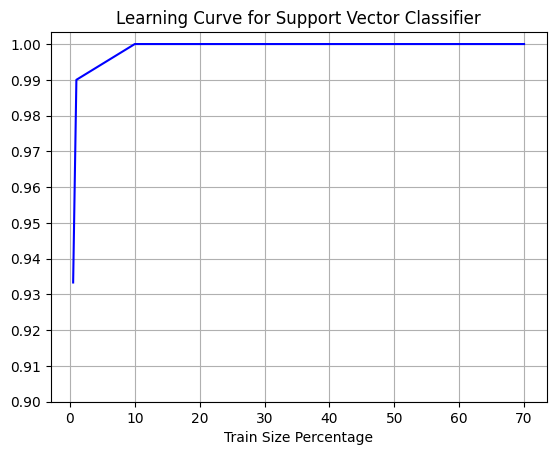

In [80]:
#===============================Learning Curve for SVC===========================================
plt.plot(training_sample,acc_SVC, color = 'b', )
plt.xticks([0,10, 20, 30, 40, 50, 60, 70])
plt.yticks([0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.0])
plt.grid()
plt.xlabel('Train Size Percentage')
plt.title('Learning Curve for Support Vector Classifier')
plt.show()

### ROC Curve for Support Vector Classifier (hPSC-EVs vs DLD-1-EVs)

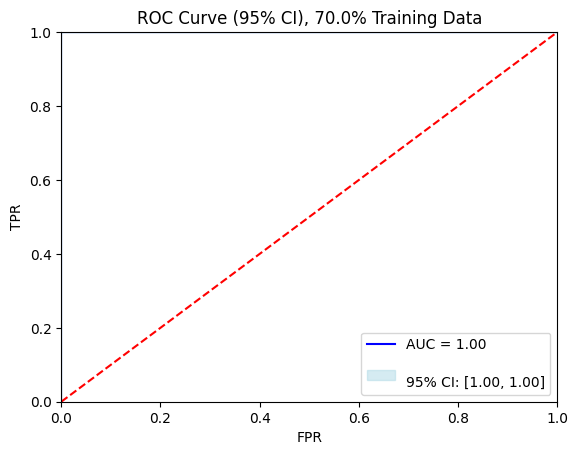

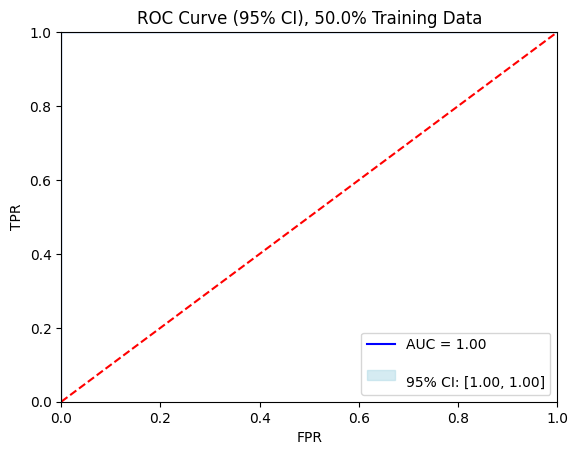

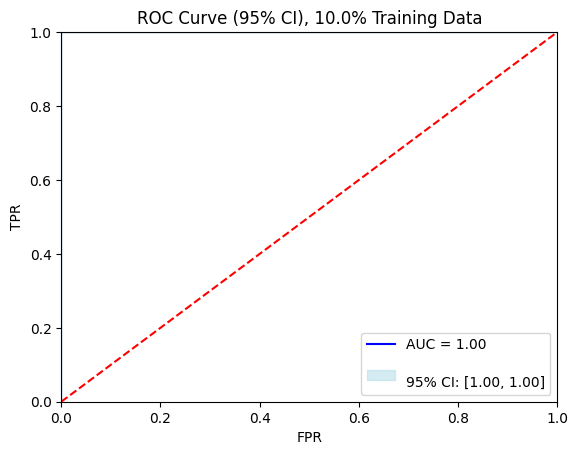

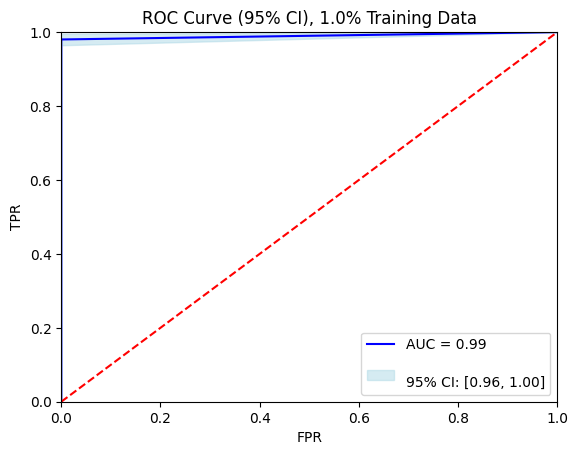

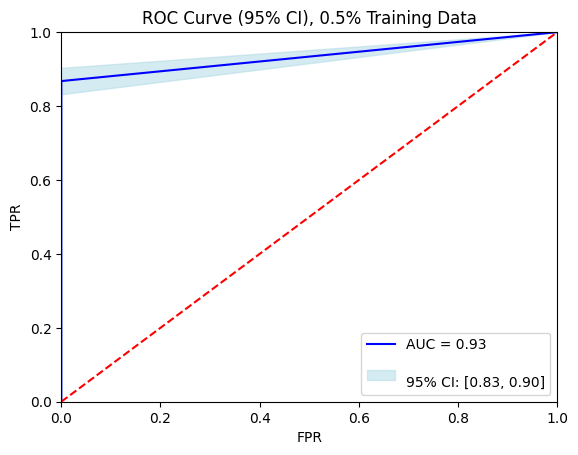

In [81]:
evaluate_ROC(train_set, y_test2, pred_SVC)

### Confusion Matrix for Support Vector Classifier (hPSC-EVs vs DLD-1-EVs)

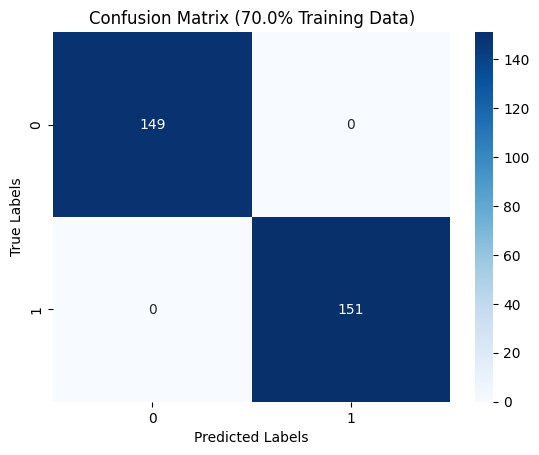

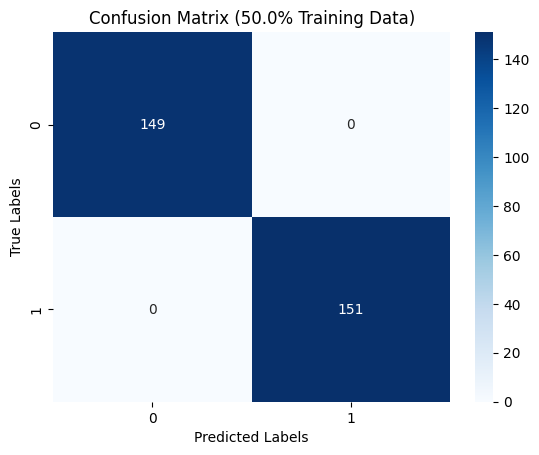

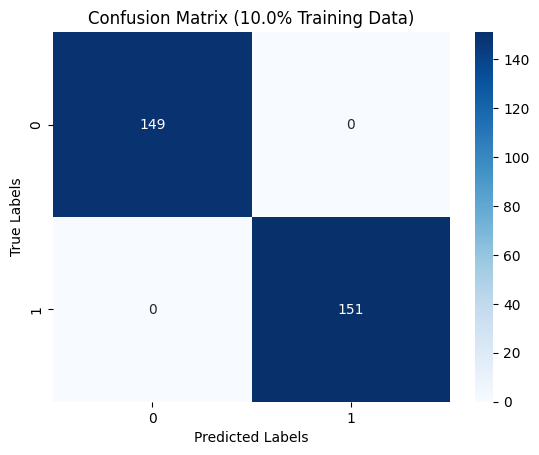

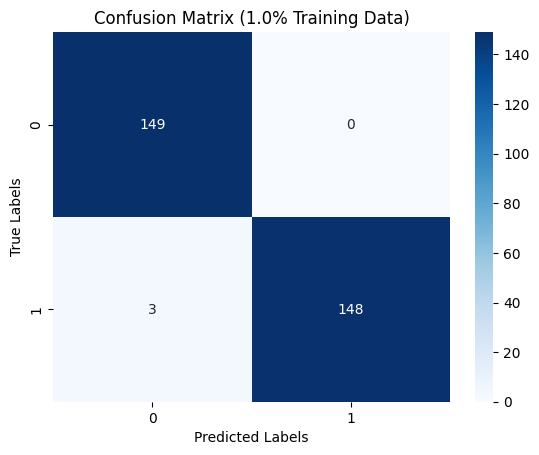

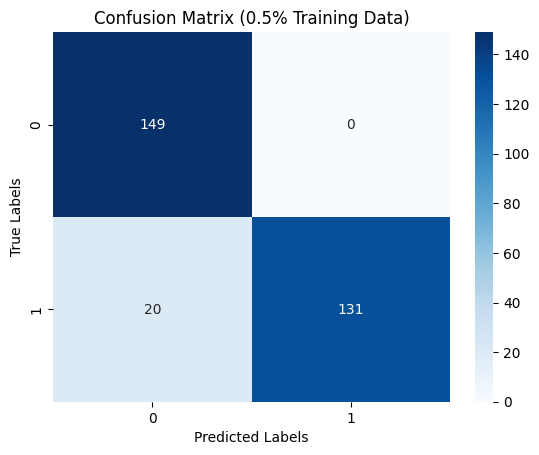

In [82]:
evaluate_con_mat(train_set, y_test2, pred_SVC)

### Cost/Loss Function of SVC Model with various Training Data (hPSC-EVs vs DLD-1-EVs)

In [83]:
for i, y_ts in enumerate(train_data):
    cost = log_loss(y_ts, pred_proba_SVC[i])
    print(f'SVC Cost: {cost:.10f} ({train_set[i]*100}% train)')

SVC Cost: 0.0493370701 (70.0% train)
SVC Cost: 0.0763434790 (50.0% train)
SVC Cost: 0.2722634437 (10.0% train)
SVC Cost: 0.4080335002 (1.0% train)
SVC Cost: 1.8529243069 (0.5% train)


In [84]:
del acc_SVC, pred_SVC, train_data, pred_proba_SVC, y_ts, best_params, clf_SVM, cost

## K Nearest Neighbors

### KNN Classifier without Hyperparameter Tuning (hPSC-EVs vs DLD-1-EVs)

In [85]:
eval_mod=evaluate_model(KNeighborsClassifier(n_neighbors=3), train_set, X_train2, y_train2, X_test2, y_test2)

Accuracy score(KNeighborsClassifier model): 1.000000 with 70.0% training records
Accuracy score(KNeighborsClassifier model): 1.000000 with 50.0% training records
Accuracy score(KNeighborsClassifier model): 1.000000 with 10.0% training records
Accuracy score(KNeighborsClassifier model): 0.933333 with 1.0% training records
Accuracy score(KNeighborsClassifier model): 0.496667 with 0.5% training records


In [86]:
del eval_mod

In [87]:
#=======================KNN Hyperparameter Tuning=========================
clf_KNN = KNeighborsClassifier(n_neighbors=3)
param_grid = {
    'n_neighbors': [3, 5, 7, 9],  # Test different values of k
    'weights': ['uniform', 'distance'],  # Weighting function
    'metric': ['euclidean', 'manhattan']  # Distance metric
}
# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(clf_KNN, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train2, y_train2)
# Get the best parameters and best estimator
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

Best hyperparameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}


Using 700 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 300/300 [00:23<00:00, 12.74it/s]


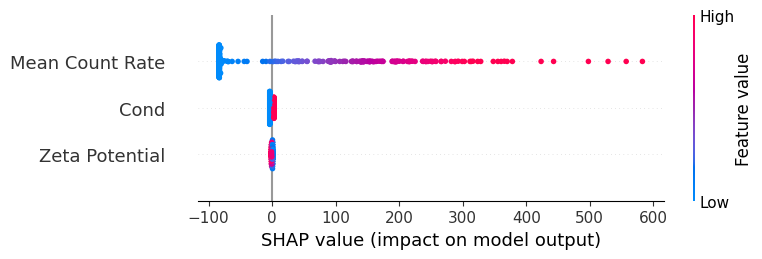

In [89]:
best_model = grid_search.best_estimator_
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train2)
X_test_norm = scaler.transform(X_test2)
# Create an explainer for the normalized model
explainer_norm = shap.KernelExplainer(best_model.predict_proba, X_train2, nsamples=100)
shap_values_norm = explainer_norm.shap_values(X_test_norm)
shap.summary_plot(shap_values, X_test2)

#### KNN with Hyperparameter Tuning (hPSC-EVs vs DLD-1-EVs)

In [90]:
acc_KNN, pred_KNN, train_data, pred_proba_KNN=evaluate_model(KNeighborsClassifier(n_neighbors=best_params['n_neighbors'], metric = best_params['metric'], weights = best_params['weights']), train_set, X_train2, y_train2, X_test2, y_test2)

Accuracy score(KNeighborsClassifier model): 1.000000 with 70.0% training records
Accuracy score(KNeighborsClassifier model): 1.000000 with 50.0% training records
Accuracy score(KNeighborsClassifier model): 1.000000 with 10.0% training records
Accuracy score(KNeighborsClassifier model): 0.933333 with 1.0% training records
Accuracy score(KNeighborsClassifier model): 0.496667 with 0.5% training records


### Learning Curve for KNN

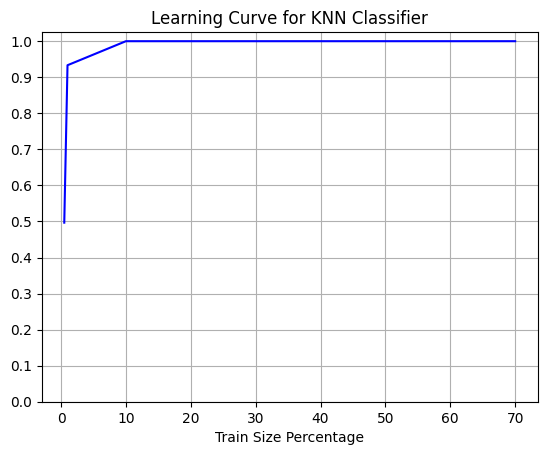

In [91]:
#===============================Learning Curve for KNN===========================================
plt.plot(training_sample,acc_KNN, color = 'b', )
plt.xticks([0,10, 20, 30, 40, 50, 60, 70])
plt.yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.grid()
plt.xlabel('Train Size Percentage')
plt.title('Learning Curve for KNN Classifier')
plt.show()

### ROC Curve for KNN Classifier (hPSC-EVs vs DLD-1-EVs)

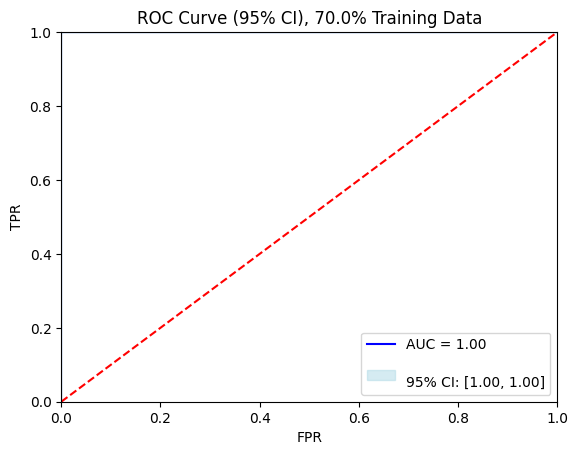

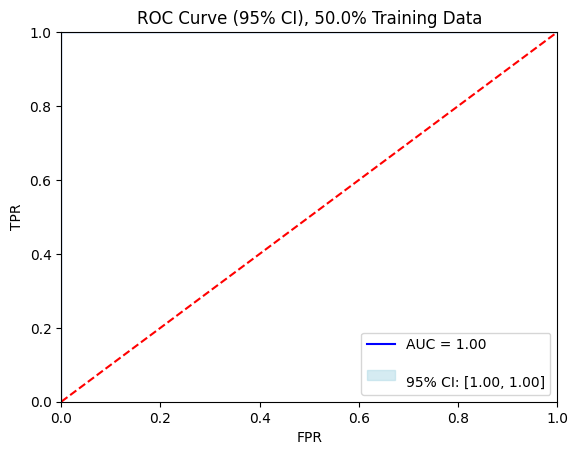

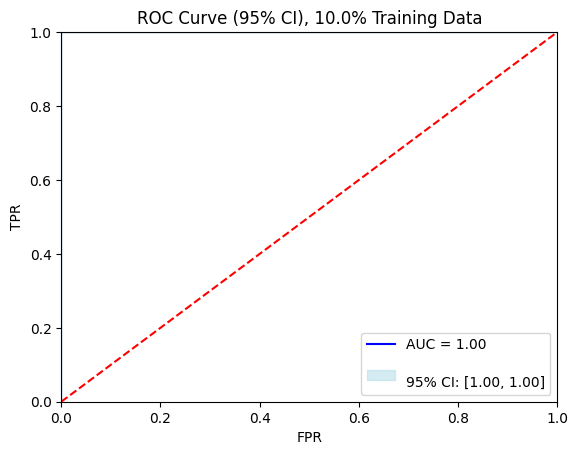

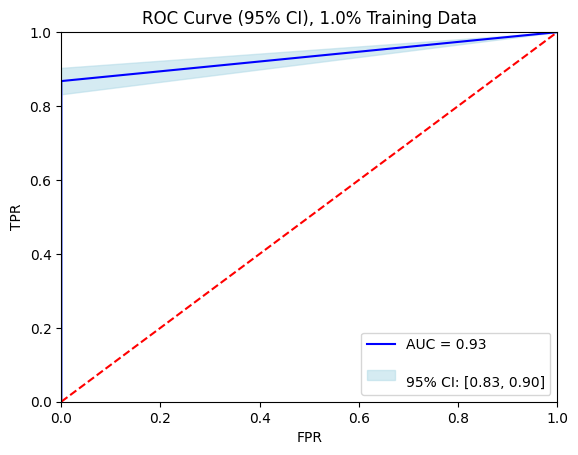

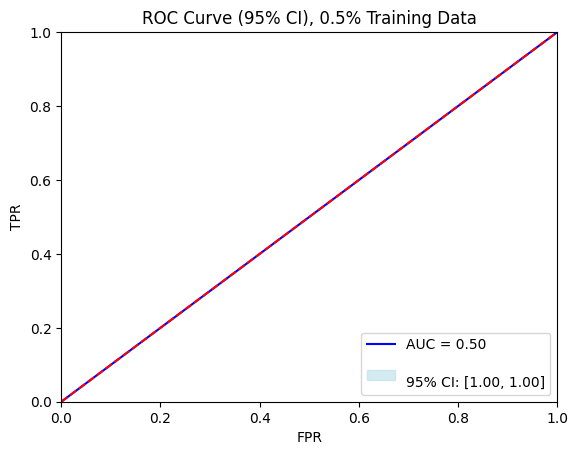

In [92]:
evaluate_ROC(train_set, y_test2, pred_KNN)

### Confusion Matrix for KNN Classifier (hPSC-EVs vs DLD-1-EVs)

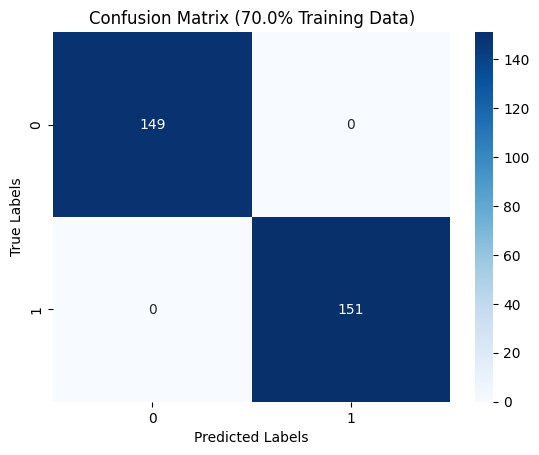

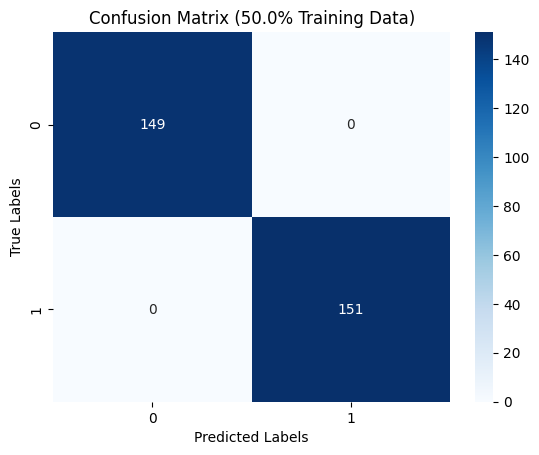

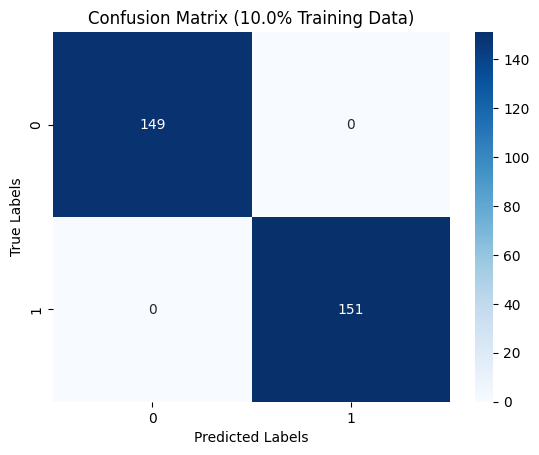

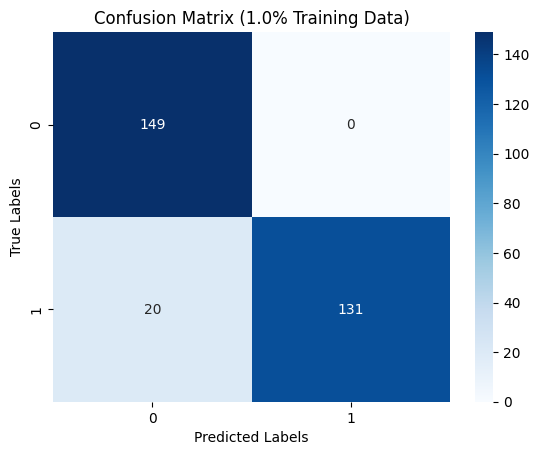

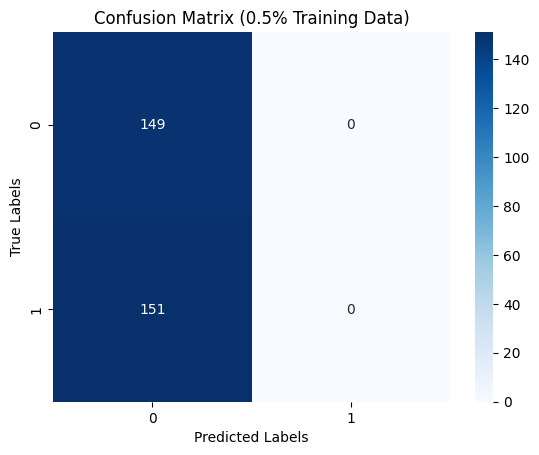

In [93]:
evaluate_con_mat(train_set, y_test2, pred_KNN)

### Cost/Loss Function of KNN Model with various Training Data (hPSC-EVs vs DLD-1-EVs)

In [94]:
for i, y_ts in enumerate(train_data):
    cost = log_loss(y_ts, pred_proba_KNN[i])
    print(f'KNN Cost: {cost:.10f} ({train_set[i]*100}% train)')

KNN Cost: 0.0000000000 (70.0% train)
KNN Cost: 0.0000000000 (50.0% train)
KNN Cost: 0.0000000000 (10.0% train)
KNN Cost: 0.2148681995 (1.0% train)
KNN Cost: 0.6365141683 (0.5% train)


In [95]:
del acc_KNN, pred_KNN, train_data, pred_proba_KNN, y_ts, best_params, clf_KNN, cost

## Decision Tree

### Decision Tree Classifier without Hyperparameter Tuning (hPSC-EVs vs DLD-1-EVs)

In [96]:
eval_mod=evaluate_model(DecisionTreeClassifier(random_state=123), train_set, X_train2, y_train2, X_test2, y_test2)

Accuracy score(DecisionTreeClassifier model): 1.000000 with 70.0% training records
Accuracy score(DecisionTreeClassifier model): 1.000000 with 50.0% training records
Accuracy score(DecisionTreeClassifier model): 1.000000 with 10.0% training records
Accuracy score(DecisionTreeClassifier model): 0.983333 with 1.0% training records
Accuracy score(DecisionTreeClassifier model): 0.933333 with 0.5% training records


In [97]:
del eval_mod

In [98]:
clf_DT = DecisionTreeClassifier(random_state=123)
# Define the hyperparameters to tune
param_grid = {
    'criterion': ['gini', 'entropy'],  # Gini Index ar Entropy
    'max_depth': [None, 10, 20, 30],   # Maximum depth of the tree
    'min_samples_split': [2, 10, 20],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 5, 10],    # Minimum samples required at a leaf node
    'max_features': [None, 'sqrt', 'log2']  # Number of features to consider when splitting
}
grid_search = GridSearchCV(estimator=clf_DT, param_grid=param_grid, cv=5, scoring='accuracy')
# Fitting the training data
grid_search.fit(X_train2, y_train2)
# Storing the best parameters used to improve the accuracy
best_params = grid_search.best_params_
print("Best Parameters:",best_params)

Best Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


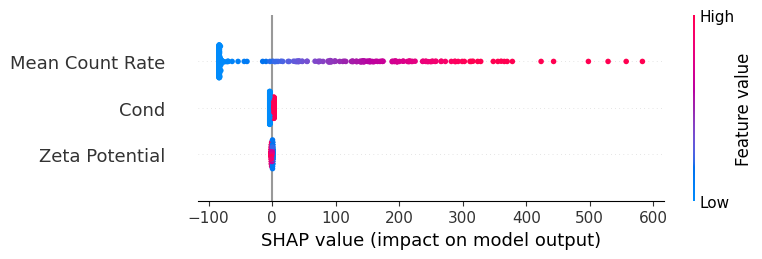

In [99]:
best_model = grid_search.best_estimator_
# Create an explainer
explainer =  shap.TreeExplainer(best_model)
shap.summary_plot(shap_values, X_test2)

### Decision Tree Classifier with Hyperparameter Tuning (hPSC-EVs vs DLD-1-EVs)

In [100]:
acc_DT, pred_DT, train_data, pred_proba_DT = evaluate_model(DecisionTreeClassifier(criterion = best_params['criterion'], max_depth = best_params['max_depth'], max_features = best_params['max_features'], min_samples_leaf = best_params['min_samples_leaf'], min_samples_split = best_params['min_samples_split']), train_set, X_train2, y_train2, X_test2, y_test2)

Accuracy score(DecisionTreeClassifier model): 1.000000 with 70.0% training records
Accuracy score(DecisionTreeClassifier model): 1.000000 with 50.0% training records
Accuracy score(DecisionTreeClassifier model): 1.000000 with 10.0% training records
Accuracy score(DecisionTreeClassifier model): 1.000000 with 1.0% training records
Accuracy score(DecisionTreeClassifier model): 0.963333 with 0.5% training records


### Learning Curve for Decision Tree

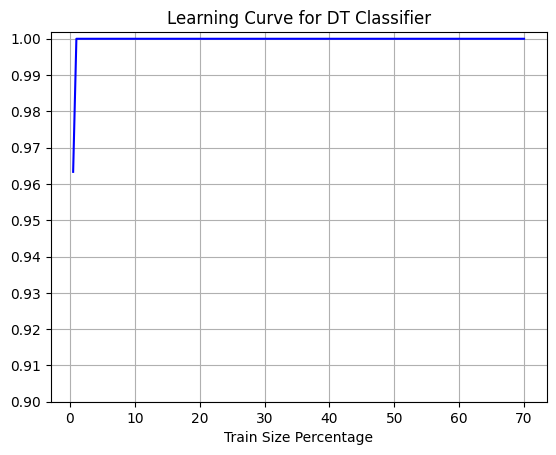

In [101]:
#===============================Learning Curve for DT===========================================
plt.plot(training_sample,acc_DT, color = 'b', )
plt.xticks([0,10, 20, 30, 40, 50, 60, 70])
plt.yticks([0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.0])
plt.grid()
plt.xlabel('Train Size Percentage')
plt.title('Learning Curve for DT Classifier')
plt.show()

### ROC Curve for Decision Tree Classifier (hPSC-EVs vs DLD-1-EVs)

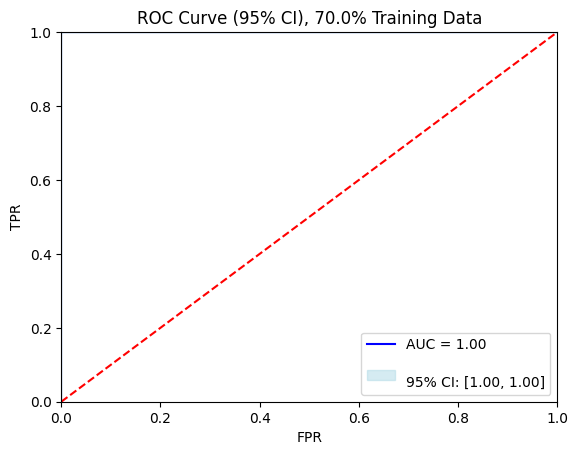

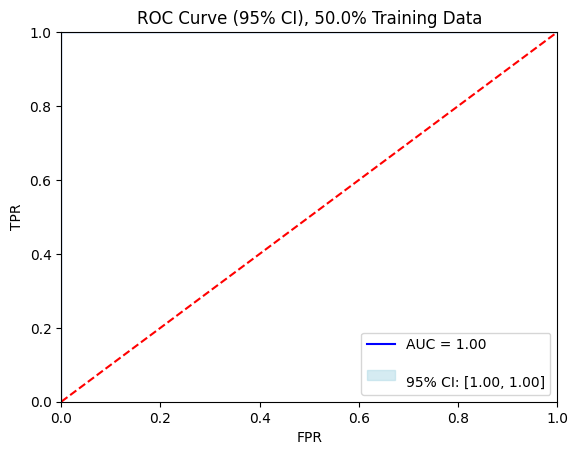

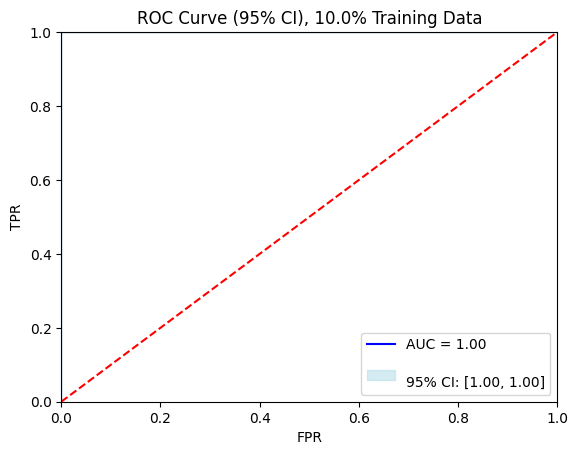

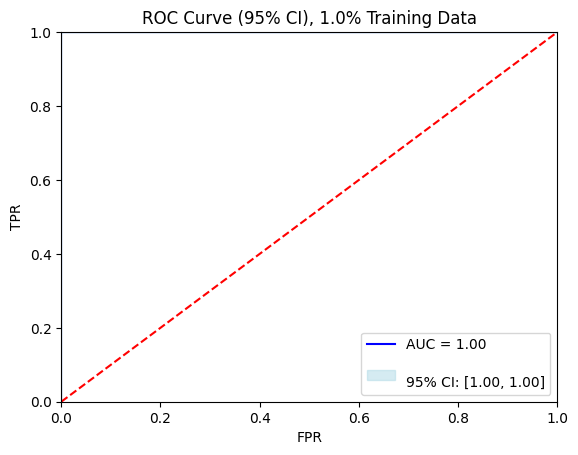

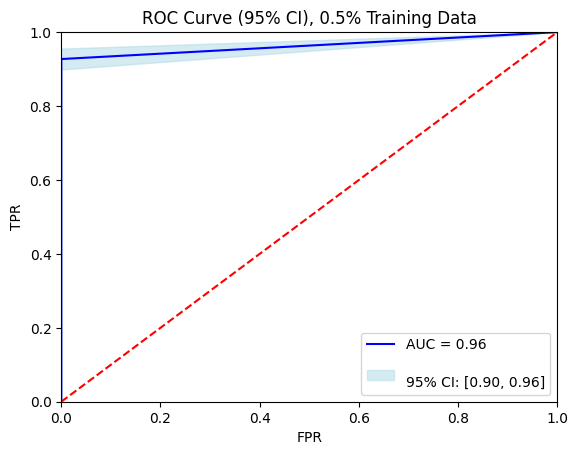

In [102]:
evaluate_ROC(train_set, y_test2, pred_DT)

### Confusion Matrix for Decision Tree Classifier (hPSC-EVs vs DLD-1-EVs)

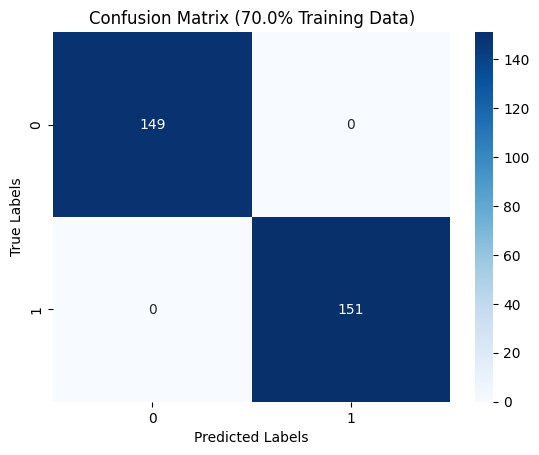

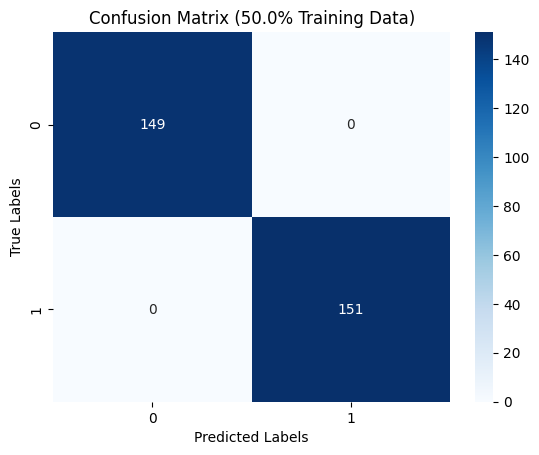

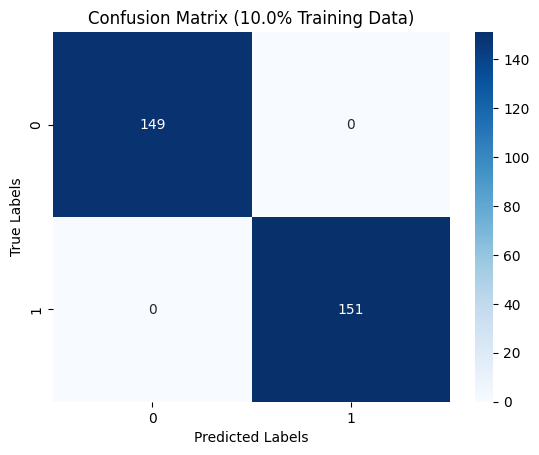

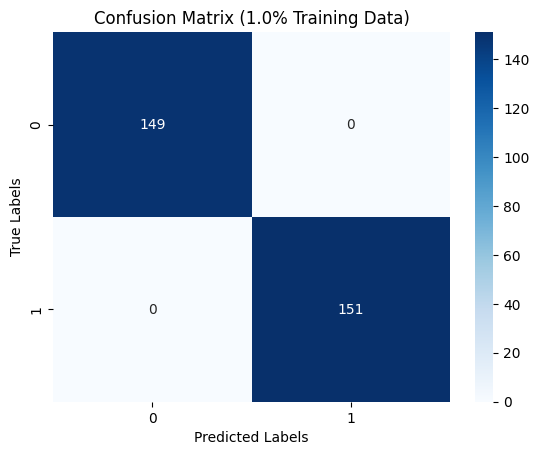

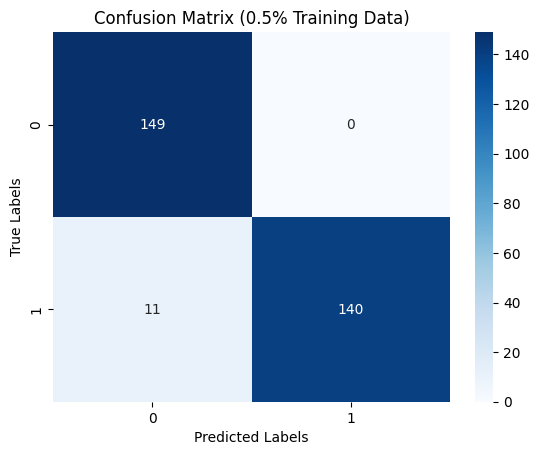

In [103]:
evaluate_con_mat(train_set, y_test2, pred_DT)

### Cost/Loss Function of DT Model with various Training Data (hPSC-EVs vs DLD-1-EVs)

In [104]:
for i, y_ts in enumerate(train_data):
    cost = log_loss(y_ts, pred_proba_DT[i])
    print(f'DT Cost: {cost:.10f} ({train_set[i]*100}% train)')

DT Cost: 0.0000000000 (70.0% train)
DT Cost: 0.0000000000 (50.0% train)
DT Cost: 0.0000000000 (10.0% train)
DT Cost: 0.0000000000 (1.0% train)
DT Cost: 0.0000000000 (0.5% train)


In [105]:
del acc_DT, pred_DT, train_data, pred_proba_DT, y_ts, best_params, clf_DT, cost

## XGBoost Classifier

### XGBoost Classifier without Hyperparameter Tuning (hPSC-EVs vs DLD-1-EVs)

In [116]:
eval_mod=evaluate_model(xgb.XGBClassifier( eval_metric='mlogloss'), train_set, X_train2, y_train2, X_test2, y_test2)

Accuracy score(XGBClassifier model): 0.996667 with 70.0% training records
Accuracy score(XGBClassifier model): 0.996667 with 50.0% training records
Accuracy score(XGBClassifier model): 0.970000 with 10.0% training records
Accuracy score(XGBClassifier model): 0.496667 with 1.0% training records
Accuracy score(XGBClassifier model): 0.496667 with 0.5% training records


In [117]:
del eval_mod

In [118]:
#=============================Hyperparameter Tuning==============================
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
xgb_clf=xgb.XGBClassifier(eval_metric='mlogloss')
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'min_child_weight': [1, 5],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8],
    'gamma': [0, 0.1]
}
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, 
                           scoring='accuracy', cv=3, verbose=0, n_jobs=-1)
# Fit the grid search to the data
grid_search.fit(X_train2, y_train2)
# Storing the best parameters used to improve the accuracy
best_params = grid_search.best_params_
print("Best Parameters:",best_params)

Best Parameters: {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.6}


### XGBoost Classifier with Hyperparameter Tuning (hPSC-EVs vs DLD-1-EVs)

In [119]:
xgb_clf=xgb.XGBClassifier(colsample_bytree=best_params['colsample_bytree'], gamma=best_params['gamma'], 
                          learning_rate=best_params['learning_rate'], max_depth=best_params['max_depth'],
                          min_child_weight=best_params['min_child_weight'], n_estimators=best_params['n_estimators'],
                          subsample=best_params['subsample'])
acc_XGB, pred_XGB, train_data, pred_proba_XGB = evaluate_model(xgb_clf, train_set, X_train2, y_train2, X_test2, y_test2)

Accuracy score(XGBClassifier model): 0.996667 with 70.0% training records
Accuracy score(XGBClassifier model): 0.996667 with 50.0% training records
Accuracy score(XGBClassifier model): 0.993333 with 10.0% training records
Accuracy score(XGBClassifier model): 0.496667 with 1.0% training records
Accuracy score(XGBClassifier model): 0.496667 with 0.5% training records


### 

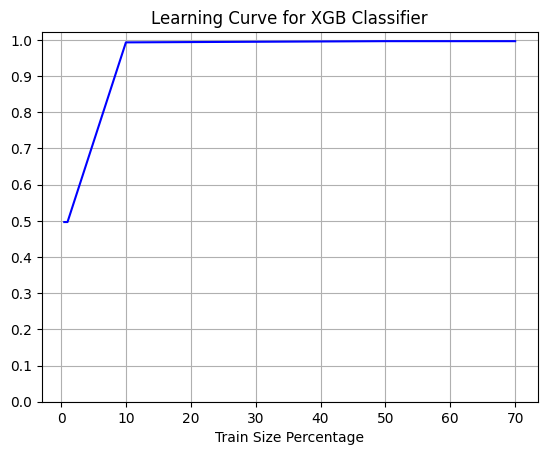

In [120]:
#===============================Learning Curve for XGB===========================================
plt.plot(training_sample,acc_XGB, color = 'b', )
plt.xticks([0,10, 20, 30, 40, 50, 60, 70])
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.grid()
plt.xlabel('Train Size Percentage')
plt.title('Learning Curve for XGB Classifier')
plt.show()

### ROC Curve for XGBoost Classifier (hPSC-EVs vs DLD-1-EVs)

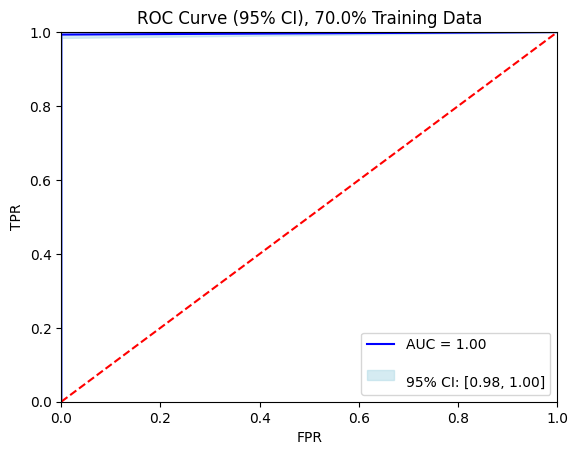

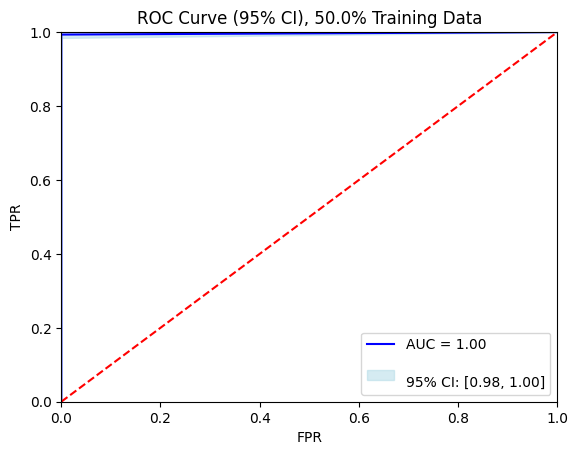

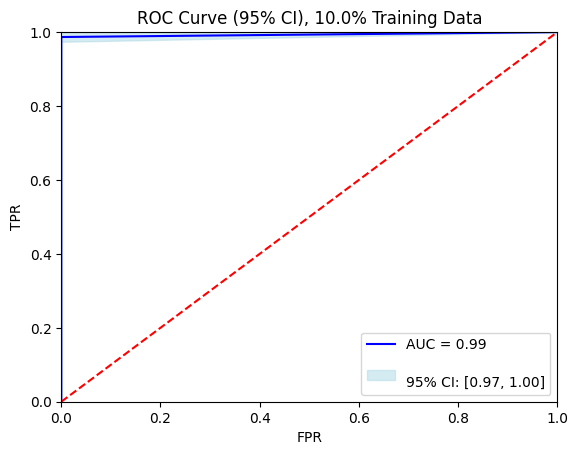

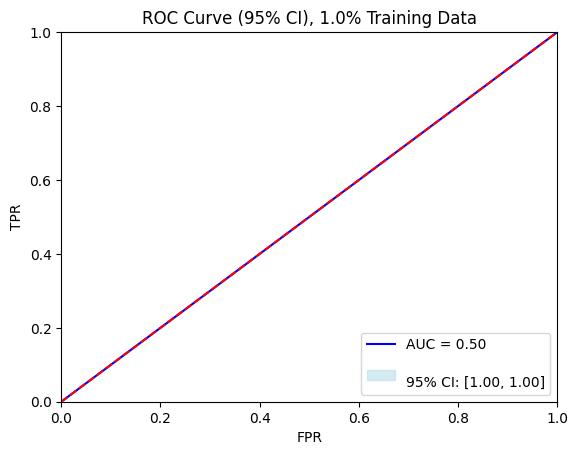

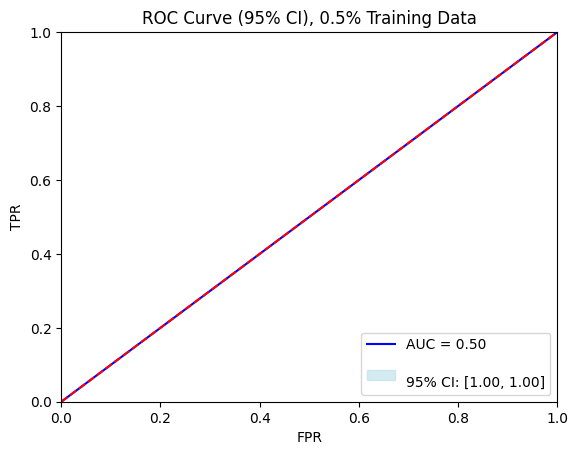

In [121]:
evaluate_ROC(train_set, y_test2, pred_XGB)

### Confusion Matrix for XGBoost Classifier (hPSC-EVs vs DLD-1-EVs)

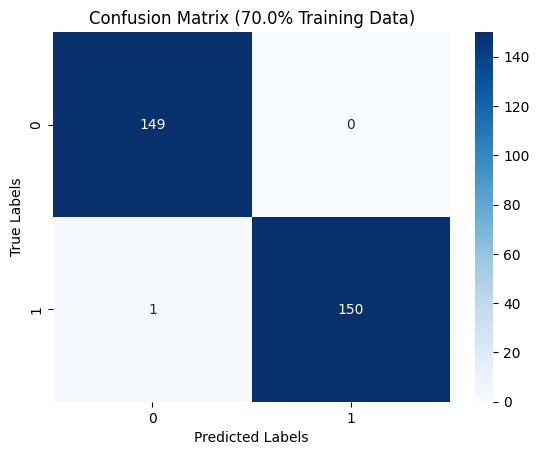

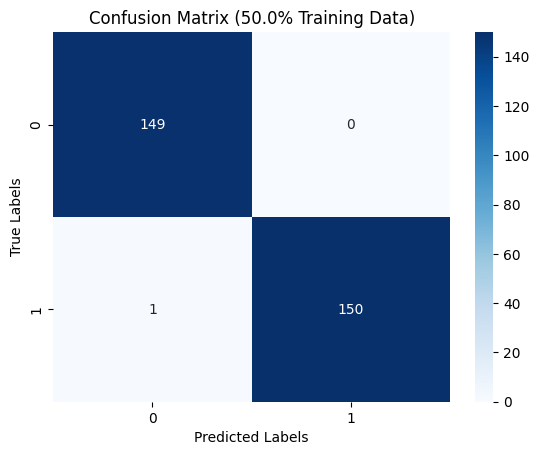

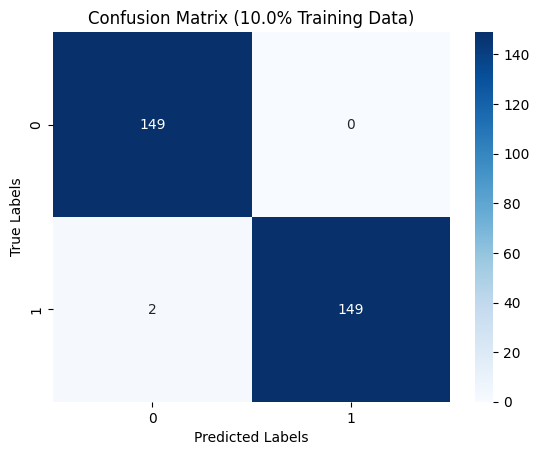

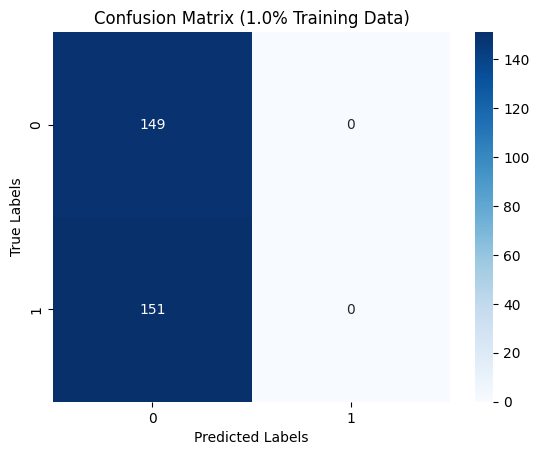

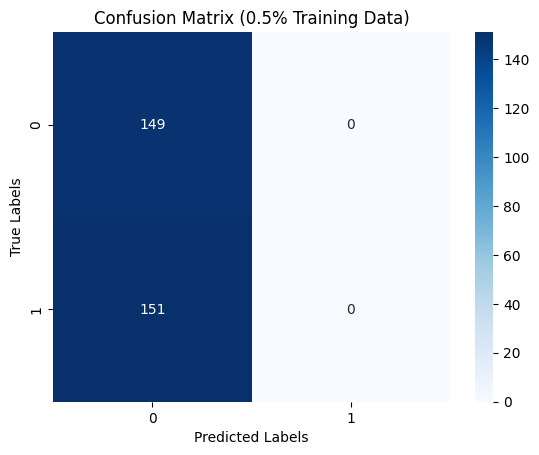

In [122]:
evaluate_con_mat(train_set, y_test2, pred_XGB)

### Cost/Loss Function of XGB Model with various Training Data (hPSC-EVs vs DLD-1-EVs)

In [123]:
for i, y_ts in enumerate(train_data):
    cost = log_loss(y_ts, pred_proba_XGB[i])
    print(f'XGB Cost: {cost:.10f} ({train_set[i]*100}% train)')

XGB Cost: 0.2157365270 (70.0% train)
XGB Cost: 0.2201404826 (50.0% train)
XGB Cost: 0.2489414389 (10.0% train)
XGB Cost: 0.5991880637 (1.0% train)
XGB Cost: 0.6365923389 (0.5% train)


In [124]:
del acc_XGB, pred_XGB, train_data, pred_proba_XGB, y_ts, best_params, xgb_clf, cost

## Vector Quantum Classifier

In [43]:
train_features2 = MinMaxScaler().fit_transform(X_train2)
train_labels2 = y_train2
test_features2 = MinMaxScaler().fit_transform(X_test2)
test_labels2 = y_test2
num_features2 = train_features2.shape[1]
feature_map2 = ZZFeatureMap(feature_dimension=num_features2, reps=1)

In [ ]:
del X_train2, y_train2

In [44]:
ansatz = EfficientSU2(num_qubits=num_features2, reps=3)

In [48]:
optimizer = op.COBYLA(maxiter=250)

In [49]:
sampler = Sampler()

### Vector Quantum Classifier with Hyperparameter Tuning (hPSC-EVs vs DLD-1-EVs)

In [47]:
#======================================VQC=================================================
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map2,
    ansatz=ansatz,
    loss = 'cross_entropy',
    optimizer=optimizer
)
acc_vqtask2 = []
pred_vqtask2 = []
for elm in train_set:
    X_t, dummy_x, y_t, dummy_y = train_test_split(train_features2, train_labels2, train_size=elm, random_state=123)
    vqc.fit(X_t, y_t.values)
    pred = vqc.predict(test_features2)
    accuracy = accuracy_score(test_labels2.values, pred)
    pred_vqtask2.append(pred)
    acc_vqtask2.append(accuracy)
    print(f'Accuracy score(VQC Model): {accuracy} with {elm*100}% training records')
#======================================VQC=================================================

Accuracy score(VQC Model): 0.9766666666666667 with 70.0% training records
Accuracy score(VQC Model): 0.9533333333333334 with 50.0% training records
Accuracy score(VQC Model): 0.99 with 10.0% training records
Accuracy score(VQC Model): 0.95 with 1.0% training records
Accuracy score(VQC Model): 0.96 with 0.5% training records


### Learning Curve for VQC

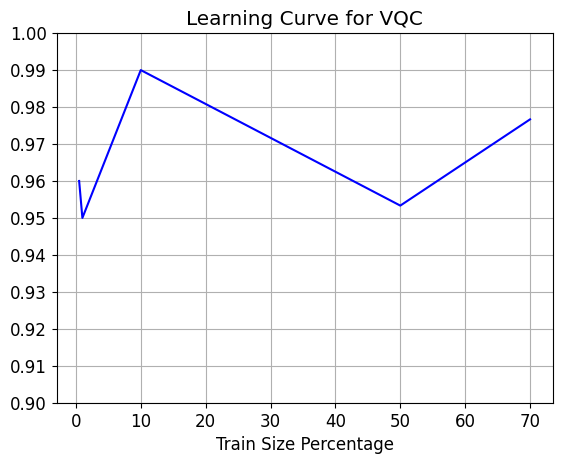

In [50]:
#===============================Learning Curve for VQC===========================================
plt.plot(training_sample,acc_vqtask2, color = 'b', )
plt.xticks([0,10, 20, 30, 40, 50, 60, 70])
plt.yticks([0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.0])
plt.grid()
plt.xlabel('Train Size Percentage')
plt.title('Learning Curve for VQC')
plt.show()

### 3D Scatter Plot for VQC Model (hPSC-EVs vs DLD-1-EVs)

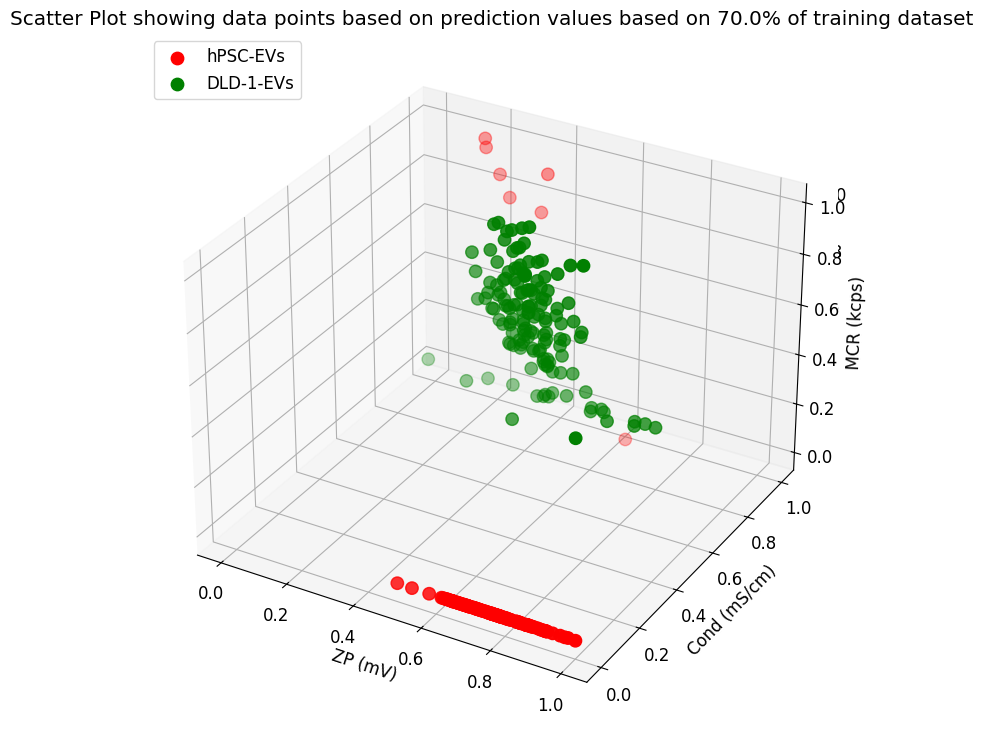

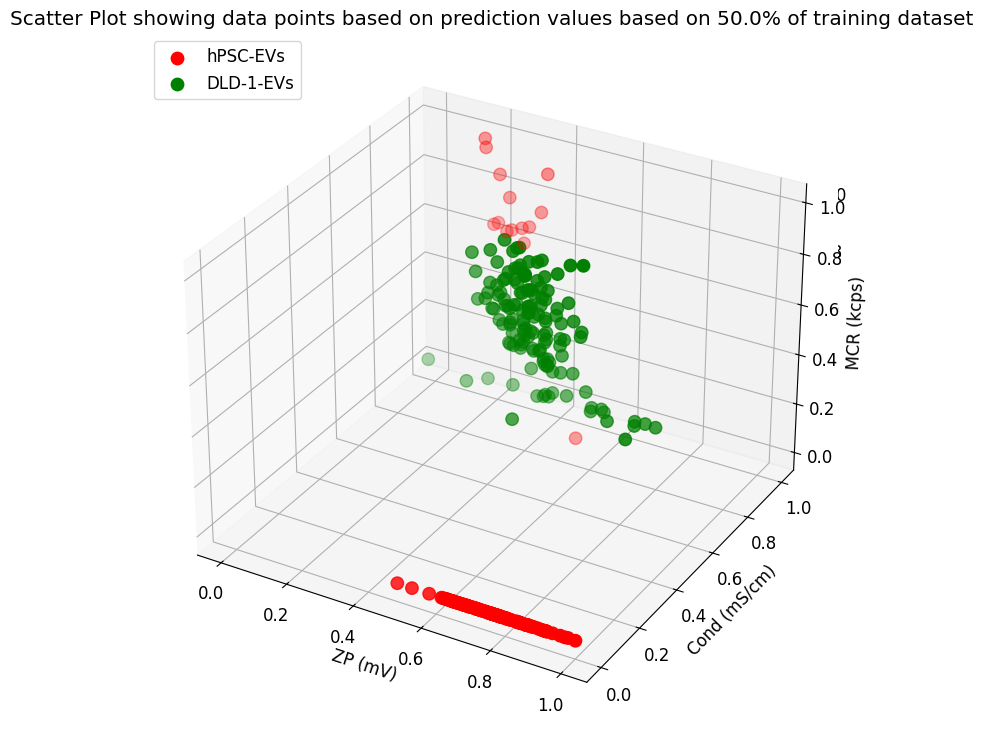

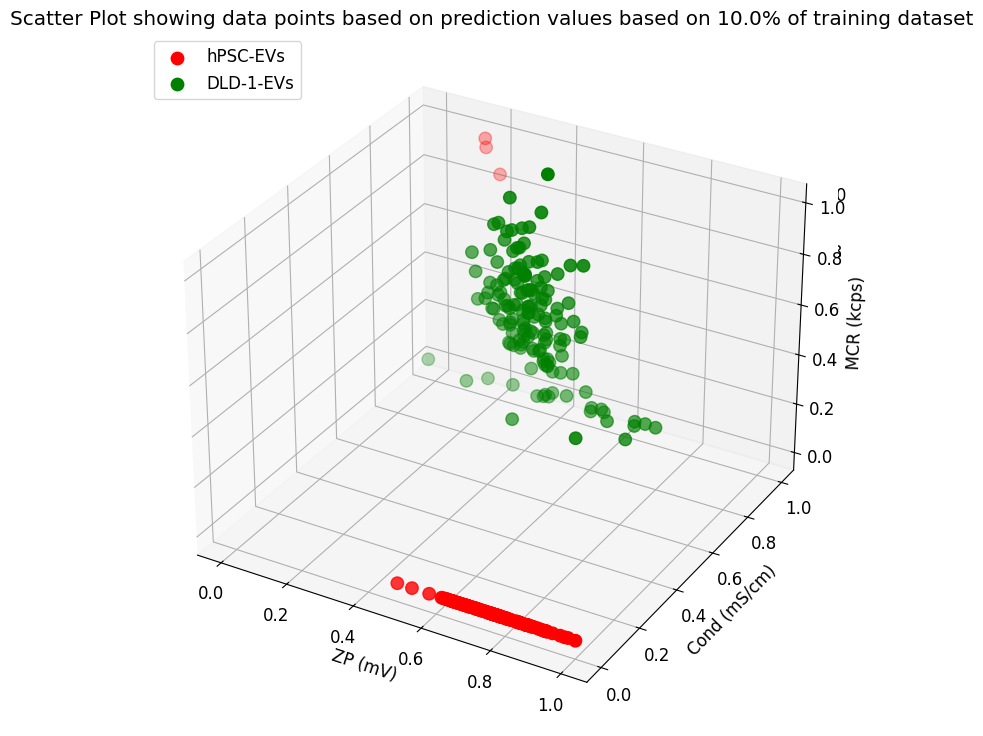

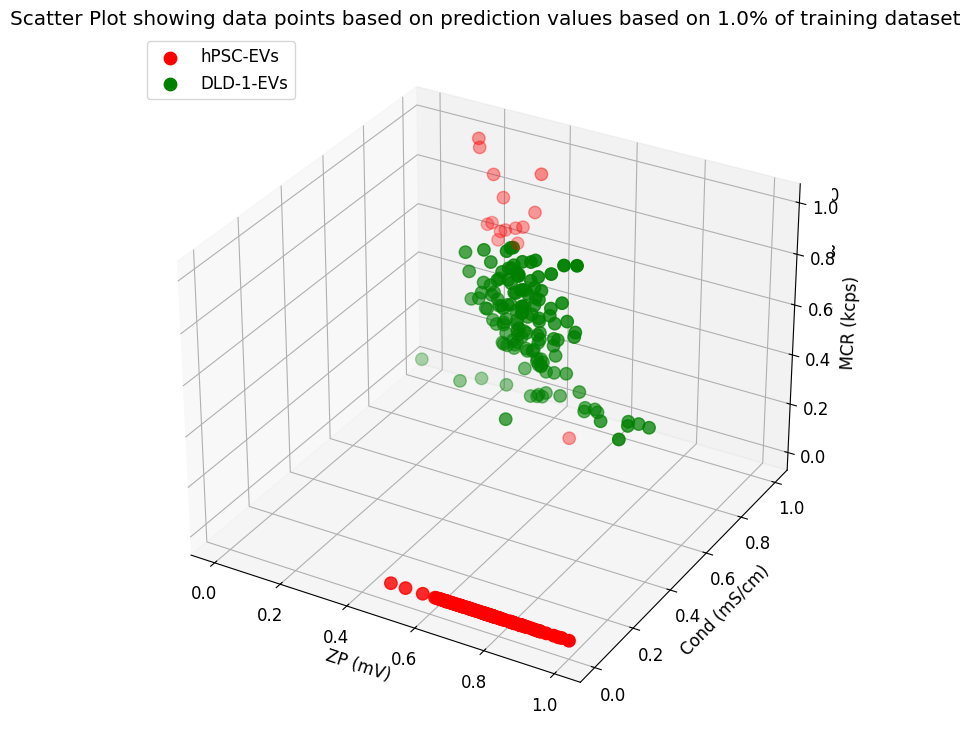

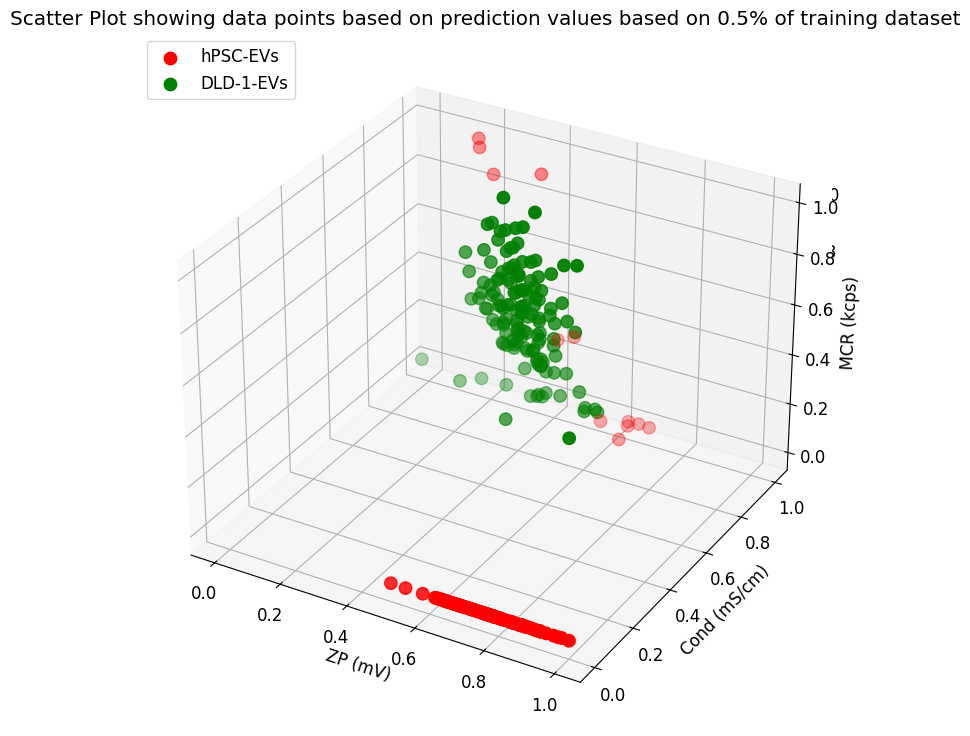

In [52]:
#=======================================3D Scatter Plot===============================
for i in range(len(train_set)):
    plt.rcParams.update({'font.size': 12})
    fig = plt.figure(figsize=(9,9))
    ax = plt.subplot(1,1,1,projection='3d')
    ax = fig.add_subplot(111,projection='3d')
    ax.scatter(test_features2[pred_vqtask2[i]==0,0], test_features2[pred_vqtask2[i]==0,1], test_features2[pred_vqtask2[i]==0,2], c='red', marker='o', label='hPSC-EVs', s=80)
    ax.scatter(test_features2[pred_vqtask2[i]==1,0], test_features2[pred_vqtask2[i]==1,1], test_features2[pred_vqtask2[i]==1,2], c='green', marker='o', label='DLD-1-EVs',s=80)
    # Set labels for each axis
    ax.set_xlabel('ZP (mV)')
    ax.set_ylabel('Cond (mS/cm)')
    ax.set_zlabel('MCR (kcps)')
    ax.set_title(f'Scatter Plot showing data points based on prediction values based on {train_set[i]*100}% of training dataset')
    ax.tick_params("z", which="major",length=15,width = 2.0)
    ax.legend(loc='upper left')
    plt.show()

### ROC Curve for Vector Quantum Classifier (hPSC-EVs vs DLD-1-EVs)

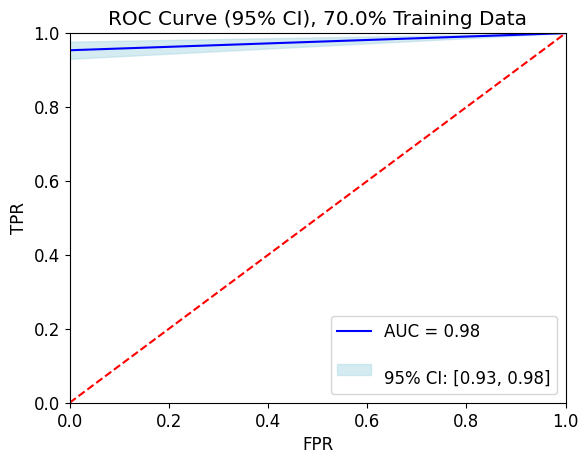

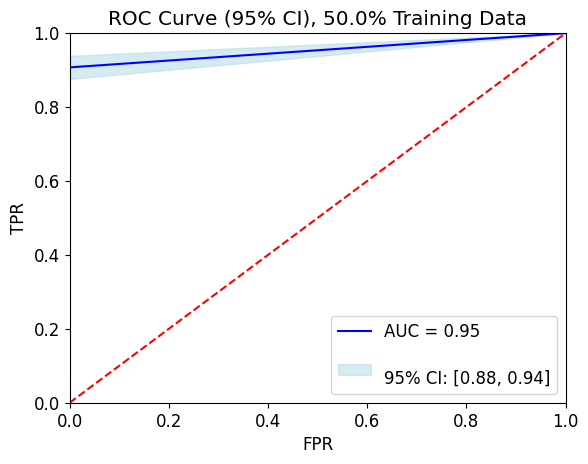

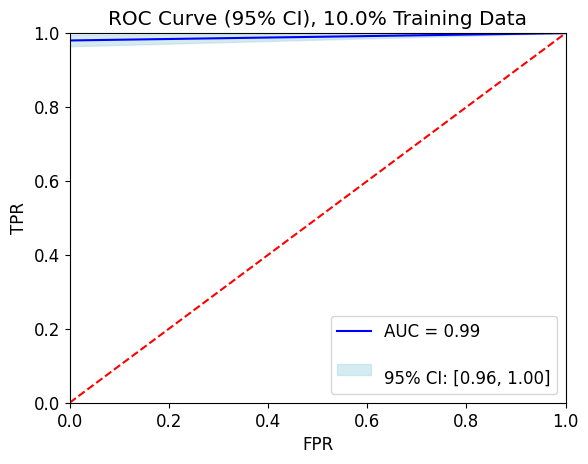

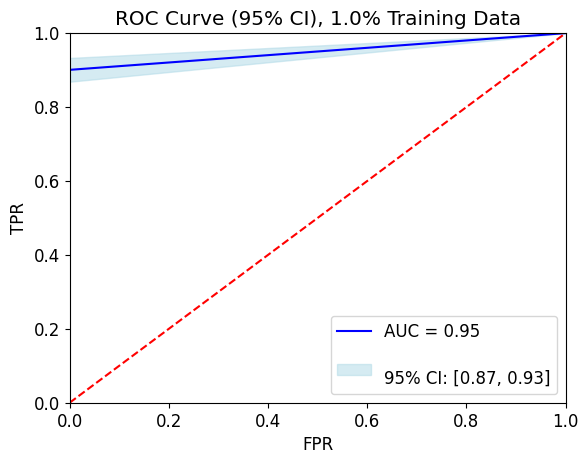

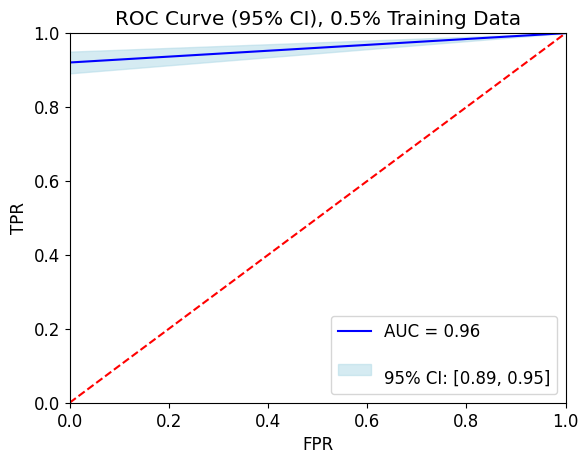

In [53]:
evaluate_ROC(train_set, test_labels2, pred_vqtask2)

### Confusion Matrix for Vector Quantum Classifier (hPSC-EVs vs DLD-1-EVs)

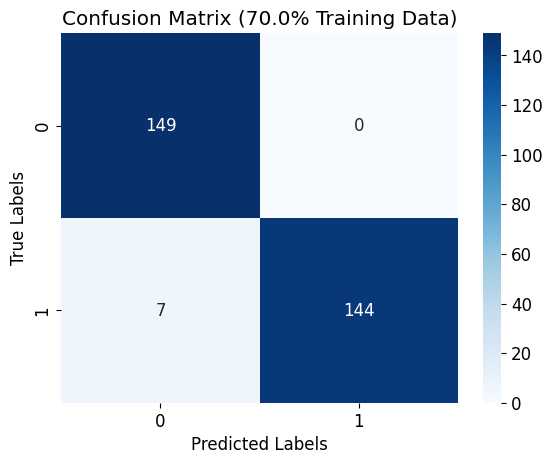

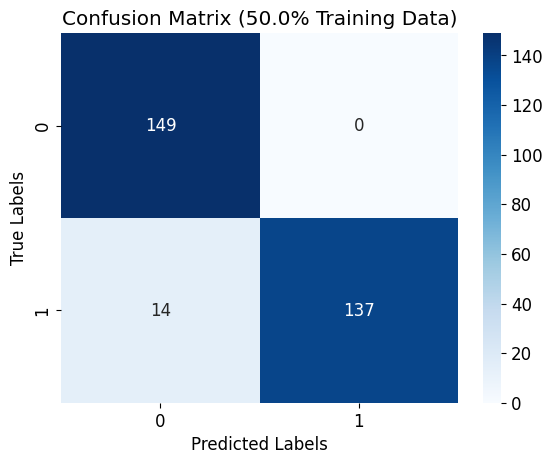

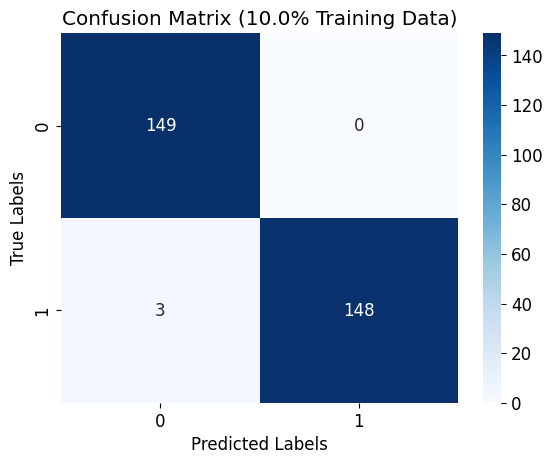

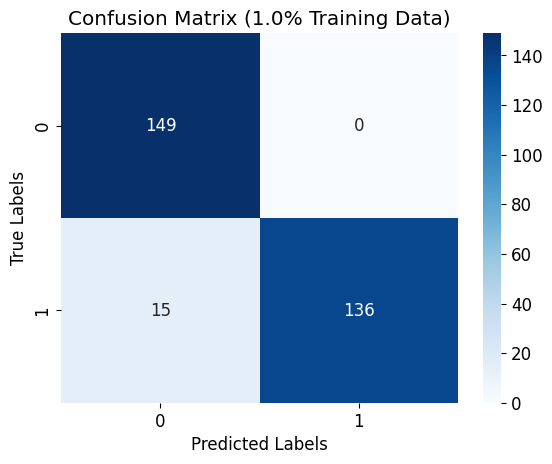

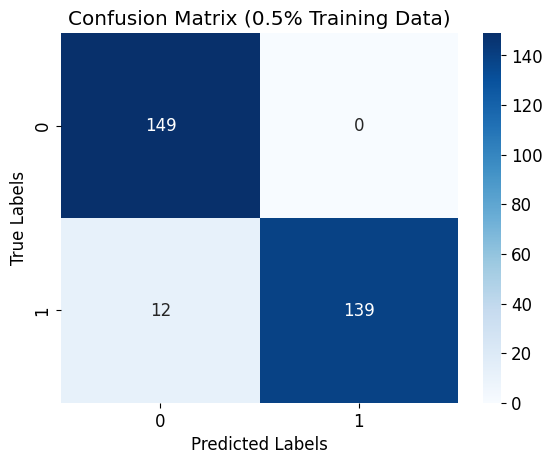

In [54]:
evaluate_con_mat(train_set, test_labels2, pred_vqtask2)

In [56]:
del train_features2, train_labels2, test_features2, test_labels2, num_features2